In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 828)
(4629816, 8)
validation
(621056, 828)
(621056, 8)
test
(624904, 828)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

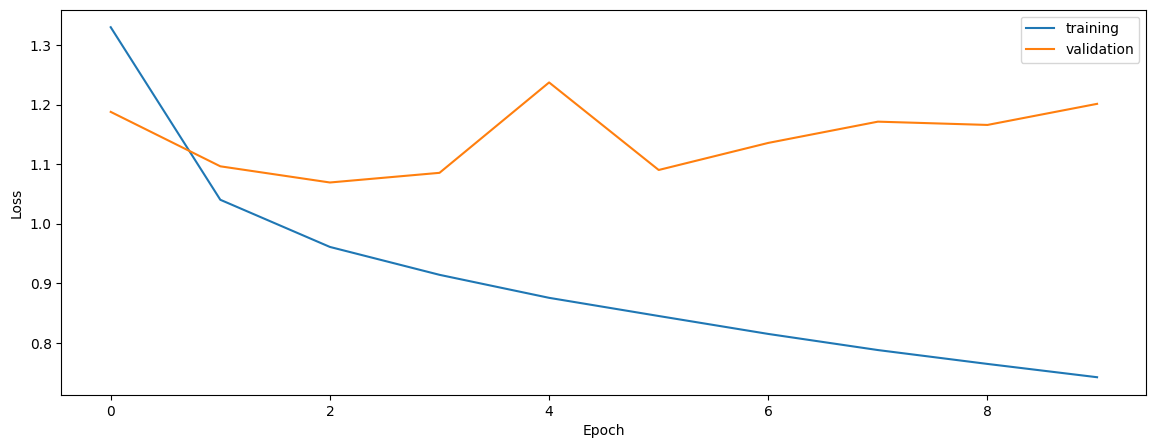

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1254584, 828)
(1254584, 1)
validation
(166224, 828)
(166224, 1)
test
(164640, 828)
(164640, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/126 [..............................] - ETA: 2:48 - loss: 0.2885 - STD: 5.7184e-05 - MAE: 0.4061

  2/126 [..............................] - ETA: 1:58 - loss: 0.2515 - STD: 2.6261e-04 - MAE: 0.4140

  4/126 [..............................] - ETA: 41s - loss: 0.2391 - STD: 5.0409e-04 - MAE: 0.4410 

  7/126 [>.............................] - ETA: 21s - loss: 0.2329 - STD: 6.2312e-04 - MAE: 0.4501

 10/126 [=>............................] - ETA: 14s - loss: 0.2290 - STD: 7.1587e-04 - MAE: 0.4441

 13/126 [==>...........................] - ETA: 11s - loss: 0.2269 - STD: 8.2153e-04 - MAE: 0.4403

 16/126 [==>...........................] - ETA: 9s - loss: 0.2251 - STD: 9.5174e-04 - MAE: 0.4413 

 19/126 [===>..........................] - ETA: 8s - loss: 0.2241 - STD: 0.0011 - MAE: 0.4435    

 22/126 [====>.........................] - ETA: 6s - loss: 0.2231 - STD: 0.0012 - MAE: 0.4442

 25/126 [====>.........................] - ETA: 6s - loss: 0.2222 - STD: 0.0013 - MAE: 0.4433

 28/126 [=====>........................] - ETA: 5s - loss: 0.2217 - STD: 0.0015 - MAE: 0.4424

 31/126 [======>.......................] - ETA: 5s - loss: 0.2211 - STD: 0.0017 - MAE: 0.4424

 34/126 [=======>......................] - ETA: 4s - loss: 0.2206 - STD: 0.0019 - MAE: 0.4427

 37/126 [=======>......................] - ETA: 4s - loss: 0.2202 - STD: 0.0023 - MAE: 0.4428

 40/126 [========>.....................] - ETA: 4s - loss: 0.2197 - STD: 0.0027 - MAE: 0.4424

 43/126 [=========>....................] - ETA: 3s - loss: 0.2194 - STD: 0.0032 - MAE: 0.4420

 46/126 [=========>....................] - ETA: 3s - loss: 0.2190 - STD: 0.0040 - MAE: 0.4418

 49/126 [==========>...................] - ETA: 3s - loss: 0.2185 - STD: 0.0050 - MAE: 0.4416

 52/126 [===========>..................] - ETA: 3s - loss: 0.2180 - STD: 0.0064 - MAE: 0.4410

 55/126 [============>.................] - ETA: 2s - loss: 0.2174 - STD: 0.0085 - MAE: 0.4403

 58/126 [============>.................] - ETA: 2s - loss: 0.2167 - STD: 0.0113 - MAE: 0.4395

 61/126 [=============>................] - ETA: 2s - loss: 0.2160 - STD: 0.0150 - MAE: 0.4384

 64/126 [==============>...............] - ETA: 2s - loss: 0.2152 - STD: 0.0192 - MAE: 0.4371

 67/126 [==============>...............] - ETA: 2s - loss: 0.2144 - STD: 0.0236 - MAE: 0.4357

 70/126 [===============>..............] - ETA: 2s - loss: 0.2136 - STD: 0.0278 - MAE: 0.4342

 73/126 [================>.............] - ETA: 1s - loss: 0.2129 - STD: 0.0318 - MAE: 0.4330

 76/126 [=================>............] - ETA: 1s - loss: 0.2122 - STD: 0.0356 - MAE: 0.4318

 79/126 [=================>............] - ETA: 1s - loss: 0.2116 - STD: 0.0394 - MAE: 0.4306

 82/126 [==================>...........] - ETA: 1s - loss: 0.2109 - STD: 0.0430 - MAE: 0.4293

 85/126 [===================>..........] - ETA: 1s - loss: 0.2103 - STD: 0.0464 - MAE: 0.4282

 88/126 [===================>..........] - ETA: 1s - loss: 0.2097 - STD: 0.0496 - MAE: 0.4271

 90/126 [====================>.........] - ETA: 1s - loss: 0.2093 - STD: 0.0517 - MAE: 0.4263

 93/126 [=====================>........] - ETA: 1s - loss: 0.2087 - STD: 0.0547 - MAE: 0.4252

 96/126 [=====================>........] - ETA: 0s - loss: 0.2081 - STD: 0.0576 - MAE: 0.4242

 99/126 [======================>.......] - ETA: 0s - loss: 0.2076 - STD: 0.0602 - MAE: 0.4232

102/126 [=======================>......] - ETA: 0s - loss: 0.2071 - STD: 0.0630 - MAE: 0.4221

105/126 [========================>.....] - ETA: 0s - loss: 0.2065 - STD: 0.0655 - MAE: 0.4212

108/126 [========================>.....] - ETA: 0s - loss: 0.2060 - STD: 0.0677 - MAE: 0.4203

111/126 [=========================>....] - ETA: 0s - loss: 0.2055 - STD: 0.0701 - MAE: 0.4194

114/126 [==========================>...] - ETA: 0s - loss: 0.2051 - STD: 0.0725 - MAE: 0.4185

117/126 [==========================>...] - ETA: 0s - loss: 0.2047 - STD: 0.0745 - MAE: 0.4177

120/126 [===========================>..] - ETA: 0s - loss: 0.2042 - STD: 0.0764 - MAE: 0.4170

123/126 [============================>.] - ETA: 0s - loss: 0.2037 - STD: 0.0785 - MAE: 0.4161

126/126 [==============================] - ETA: 0s - loss: 0.2033 - STD: 0.0806 - MAE: 0.4153

126/126 [==============================] - 6s 37ms/step - loss: 0.2033 - STD: 0.0806 - MAE: 0.4153 - val_loss: 0.1918 - val_STD: 0.1141 - val_MAE: 0.3833


Epoch 2/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1874 - STD: 0.1529 - MAE: 0.3811

  4/126 [..............................] - ETA: 2s - loss: 0.1850 - STD: 0.1591 - MAE: 0.3810

  7/126 [>.............................] - ETA: 2s - loss: 0.1850 - STD: 0.1628 - MAE: 0.3809

 10/126 [=>............................] - ETA: 2s - loss: 0.1848 - STD: 0.1660 - MAE: 0.3801

 13/126 [==>...........................] - ETA: 2s - loss: 0.1845 - STD: 0.1668 - MAE: 0.3791

 16/126 [==>...........................] - ETA: 2s - loss: 0.1846 - STD: 0.1675 - MAE: 0.3793

 19/126 [===>..........................] - ETA: 2s - loss: 0.1843 - STD: 0.1678 - MAE: 0.3791

 22/126 [====>.........................] - ETA: 2s - loss: 0.1841 - STD: 0.1686 - MAE: 0.3788

 25/126 [====>.........................] - ETA: 2s - loss: 0.1839 - STD: 0.1691 - MAE: 0.3783

 28/126 [=====>........................] - ETA: 2s - loss: 0.1834 - STD: 0.1703 - MAE: 0.3775

 31/126 [======>.......................] - ETA: 2s - loss: 0.1831 - STD: 0.1715 - MAE: 0.3769

 34/126 [=======>......................] - ETA: 2s - loss: 0.1830 - STD: 0.1724 - MAE: 0.3767

 37/126 [=======>......................] - ETA: 2s - loss: 0.1828 - STD: 0.1730 - MAE: 0.3763

 40/126 [========>.....................] - ETA: 1s - loss: 0.1827 - STD: 0.1735 - MAE: 0.3759

 43/126 [=========>....................] - ETA: 1s - loss: 0.1824 - STD: 0.1743 - MAE: 0.3754

 46/126 [=========>....................] - ETA: 1s - loss: 0.1822 - STD: 0.1749 - MAE: 0.3751

 49/126 [==========>...................] - ETA: 1s - loss: 0.1821 - STD: 0.1751 - MAE: 0.3749

 52/126 [===========>..................] - ETA: 1s - loss: 0.1822 - STD: 0.1757 - MAE: 0.3749

 55/126 [============>.................] - ETA: 1s - loss: 0.1820 - STD: 0.1763 - MAE: 0.3746

 58/126 [============>.................] - ETA: 1s - loss: 0.1819 - STD: 0.1767 - MAE: 0.3743

 60/126 [=============>................] - ETA: 1s - loss: 0.1819 - STD: 0.1767 - MAE: 0.3742

 63/126 [==============>...............] - ETA: 1s - loss: 0.1817 - STD: 0.1770 - MAE: 0.3740

 66/126 [==============>...............] - ETA: 1s - loss: 0.1815 - STD: 0.1773 - MAE: 0.3737

 69/126 [===============>..............] - ETA: 1s - loss: 0.1813 - STD: 0.1779 - MAE: 0.3733

 72/126 [================>.............] - ETA: 1s - loss: 0.1812 - STD: 0.1785 - MAE: 0.3729

 74/126 [================>.............] - ETA: 1s - loss: 0.1810 - STD: 0.1788 - MAE: 0.3728

 77/126 [=================>............] - ETA: 1s - loss: 0.1808 - STD: 0.1791 - MAE: 0.3725

 80/126 [==================>...........] - ETA: 1s - loss: 0.1807 - STD: 0.1796 - MAE: 0.3722

 83/126 [==================>...........] - ETA: 0s - loss: 0.1805 - STD: 0.1801 - MAE: 0.3718

 86/126 [===================>..........] - ETA: 0s - loss: 0.1804 - STD: 0.1806 - MAE: 0.3715

 89/126 [====================>.........] - ETA: 0s - loss: 0.1802 - STD: 0.1809 - MAE: 0.3713

 92/126 [====================>.........] - ETA: 0s - loss: 0.1800 - STD: 0.1814 - MAE: 0.3710

 95/126 [=====================>........] - ETA: 0s - loss: 0.1798 - STD: 0.1819 - MAE: 0.3706

 98/126 [======================>.......] - ETA: 0s - loss: 0.1796 - STD: 0.1825 - MAE: 0.3703

101/126 [=======================>......] - ETA: 0s - loss: 0.1795 - STD: 0.1828 - MAE: 0.3701

104/126 [=======================>......] - ETA: 0s - loss: 0.1794 - STD: 0.1833 - MAE: 0.3698

107/126 [========================>.....] - ETA: 0s - loss: 0.1792 - STD: 0.1839 - MAE: 0.3694

110/126 [=========================>....] - ETA: 0s - loss: 0.1791 - STD: 0.1844 - MAE: 0.3692

113/126 [=========================>....] - ETA: 0s - loss: 0.1790 - STD: 0.1846 - MAE: 0.3689

116/126 [==========================>...] - ETA: 0s - loss: 0.1788 - STD: 0.1851 - MAE: 0.3686

119/126 [===========================>..] - ETA: 0s - loss: 0.1786 - STD: 0.1855 - MAE: 0.3682

122/126 [============================>.] - ETA: 0s - loss: 0.1784 - STD: 0.1859 - MAE: 0.3679

125/126 [============================>.] - ETA: 0s - loss: 0.1782 - STD: 0.1863 - MAE: 0.3676

126/126 [==============================] - 3s 25ms/step - loss: 0.1781 - STD: 0.1864 - MAE: 0.3675 - val_loss: 0.1804 - val_STD: 0.1697 - val_MAE: 0.3637


Epoch 3/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1716 - STD: 0.2087 - MAE: 0.3551

  4/126 [..............................] - ETA: 2s - loss: 0.1709 - STD: 0.2107 - MAE: 0.3536

  7/126 [>.............................] - ETA: 2s - loss: 0.1702 - STD: 0.2109 - MAE: 0.3527

 10/126 [=>............................] - ETA: 2s - loss: 0.1706 - STD: 0.2098 - MAE: 0.3519

 13/126 [==>...........................] - ETA: 2s - loss: 0.1706 - STD: 0.2110 - MAE: 0.3517

 16/126 [==>...........................] - ETA: 2s - loss: 0.1705 - STD: 0.2100 - MAE: 0.3519

 19/126 [===>..........................] - ETA: 2s - loss: 0.1707 - STD: 0.2101 - MAE: 0.3523

 22/126 [====>.........................] - ETA: 2s - loss: 0.1709 - STD: 0.2097 - MAE: 0.3527

 25/126 [====>.........................] - ETA: 2s - loss: 0.1707 - STD: 0.2093 - MAE: 0.3526

 28/126 [=====>........................] - ETA: 2s - loss: 0.1707 - STD: 0.2094 - MAE: 0.3525

 30/126 [======>.......................] - ETA: 2s - loss: 0.1705 - STD: 0.2094 - MAE: 0.3523

 33/126 [======>.......................] - ETA: 2s - loss: 0.1702 - STD: 0.2094 - MAE: 0.3521

 36/126 [=======>......................] - ETA: 2s - loss: 0.1700 - STD: 0.2100 - MAE: 0.3519

 39/126 [========>.....................] - ETA: 1s - loss: 0.1700 - STD: 0.2105 - MAE: 0.3516

 42/126 [=========>....................] - ETA: 1s - loss: 0.1699 - STD: 0.2106 - MAE: 0.3516

 45/126 [=========>....................] - ETA: 1s - loss: 0.1698 - STD: 0.2110 - MAE: 0.3514

 48/126 [==========>...................] - ETA: 1s - loss: 0.1697 - STD: 0.2114 - MAE: 0.3510

 51/126 [===========>..................] - ETA: 1s - loss: 0.1697 - STD: 0.2115 - MAE: 0.3509

 54/126 [===========>..................] - ETA: 1s - loss: 0.1695 - STD: 0.2116 - MAE: 0.3506

 57/126 [============>.................] - ETA: 1s - loss: 0.1694 - STD: 0.2119 - MAE: 0.3504

 59/126 [=============>................] - ETA: 1s - loss: 0.1694 - STD: 0.2120 - MAE: 0.3505

 62/126 [=============>................] - ETA: 1s - loss: 0.1694 - STD: 0.2120 - MAE: 0.3504

 65/126 [==============>...............] - ETA: 1s - loss: 0.1696 - STD: 0.2119 - MAE: 0.3504

 68/126 [===============>..............] - ETA: 1s - loss: 0.1696 - STD: 0.2120 - MAE: 0.3502

 71/126 [===============>..............] - ETA: 1s - loss: 0.1696 - STD: 0.2118 - MAE: 0.3502

 74/126 [================>.............] - ETA: 1s - loss: 0.1695 - STD: 0.2116 - MAE: 0.3503

 77/126 [=================>............] - ETA: 1s - loss: 0.1694 - STD: 0.2116 - MAE: 0.3502

 80/126 [==================>...........] - ETA: 1s - loss: 0.1692 - STD: 0.2117 - MAE: 0.3501

 83/126 [==================>...........] - ETA: 0s - loss: 0.1691 - STD: 0.2117 - MAE: 0.3500

 86/126 [===================>..........] - ETA: 0s - loss: 0.1690 - STD: 0.2120 - MAE: 0.3498

 88/126 [===================>..........] - ETA: 0s - loss: 0.1690 - STD: 0.2122 - MAE: 0.3497

 91/126 [====================>.........] - ETA: 0s - loss: 0.1689 - STD: 0.2125 - MAE: 0.3495

 94/126 [=====================>........] - ETA: 0s - loss: 0.1688 - STD: 0.2129 - MAE: 0.3493

 97/126 [======================>.......] - ETA: 0s - loss: 0.1686 - STD: 0.2132 - MAE: 0.3490

100/126 [======================>.......] - ETA: 0s - loss: 0.1685 - STD: 0.2135 - MAE: 0.3489

103/126 [=======================>......] - ETA: 0s - loss: 0.1683 - STD: 0.2138 - MAE: 0.3486

106/126 [========================>.....] - ETA: 0s - loss: 0.1683 - STD: 0.2140 - MAE: 0.3485

109/126 [========================>.....] - ETA: 0s - loss: 0.1681 - STD: 0.2144 - MAE: 0.3483

112/126 [=========================>....] - ETA: 0s - loss: 0.1681 - STD: 0.2147 - MAE: 0.3481

115/126 [==========================>...] - ETA: 0s - loss: 0.1680 - STD: 0.2149 - MAE: 0.3479

118/126 [===========================>..] - ETA: 0s - loss: 0.1678 - STD: 0.2151 - MAE: 0.3477

121/126 [===========================>..] - ETA: 0s - loss: 0.1678 - STD: 0.2154 - MAE: 0.3476

124/126 [============================>.] - ETA: 0s - loss: 0.1678 - STD: 0.2156 - MAE: 0.3475

126/126 [==============================] - 3s 25ms/step - loss: 0.1678 - STD: 0.2156 - MAE: 0.3473 - val_loss: 0.1843 - val_STD: 0.1929 - val_MAE: 0.3653


Epoch 4/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1727 - STD: 0.2321 - MAE: 0.3527

  4/126 [..............................] - ETA: 2s - loss: 0.1665 - STD: 0.2234 - MAE: 0.3430

  7/126 [>.............................] - ETA: 2s - loss: 0.1669 - STD: 0.2176 - MAE: 0.3451

 10/126 [=>............................] - ETA: 2s - loss: 0.1663 - STD: 0.2168 - MAE: 0.3454

 13/126 [==>...........................] - ETA: 2s - loss: 0.1658 - STD: 0.2183 - MAE: 0.3448

 16/126 [==>...........................] - ETA: 2s - loss: 0.1659 - STD: 0.2179 - MAE: 0.3451

 19/126 [===>..........................] - ETA: 2s - loss: 0.1660 - STD: 0.2173 - MAE: 0.3452

 22/126 [====>.........................] - ETA: 2s - loss: 0.1658 - STD: 0.2178 - MAE: 0.3445

 25/126 [====>.........................] - ETA: 2s - loss: 0.1657 - STD: 0.2185 - MAE: 0.3442

 28/126 [=====>........................] - ETA: 2s - loss: 0.1654 - STD: 0.2188 - MAE: 0.3439

 31/126 [======>.......................] - ETA: 2s - loss: 0.1651 - STD: 0.2195 - MAE: 0.3435

 34/126 [=======>......................] - ETA: 2s - loss: 0.1650 - STD: 0.2202 - MAE: 0.3432

 37/126 [=======>......................] - ETA: 2s - loss: 0.1651 - STD: 0.2207 - MAE: 0.3431

 40/126 [========>.....................] - ETA: 1s - loss: 0.1648 - STD: 0.2211 - MAE: 0.3427

 43/126 [=========>....................] - ETA: 1s - loss: 0.1647 - STD: 0.2217 - MAE: 0.3423

 46/126 [=========>....................] - ETA: 1s - loss: 0.1644 - STD: 0.2225 - MAE: 0.3418

 49/126 [==========>...................] - ETA: 1s - loss: 0.1642 - STD: 0.2229 - MAE: 0.3415

 52/126 [===========>..................] - ETA: 1s - loss: 0.1641 - STD: 0.2232 - MAE: 0.3413

 55/126 [============>.................] - ETA: 1s - loss: 0.1639 - STD: 0.2235 - MAE: 0.3410

 58/126 [============>.................] - ETA: 1s - loss: 0.1640 - STD: 0.2240 - MAE: 0.3409

 61/126 [=============>................] - ETA: 1s - loss: 0.1638 - STD: 0.2243 - MAE: 0.3406

 64/126 [==============>...............] - ETA: 1s - loss: 0.1637 - STD: 0.2245 - MAE: 0.3404

 67/126 [==============>...............] - ETA: 1s - loss: 0.1636 - STD: 0.2248 - MAE: 0.3402

 70/126 [===============>..............] - ETA: 1s - loss: 0.1637 - STD: 0.2249 - MAE: 0.3401

 73/126 [================>.............] - ETA: 1s - loss: 0.1637 - STD: 0.2250 - MAE: 0.3402

 76/126 [=================>............] - ETA: 1s - loss: 0.1638 - STD: 0.2250 - MAE: 0.3401

 79/126 [=================>............] - ETA: 1s - loss: 0.1638 - STD: 0.2249 - MAE: 0.3401

 82/126 [==================>...........] - ETA: 0s - loss: 0.1639 - STD: 0.2249 - MAE: 0.3403

 85/126 [===================>..........] - ETA: 0s - loss: 0.1639 - STD: 0.2246 - MAE: 0.3403

 88/126 [===================>..........] - ETA: 0s - loss: 0.1639 - STD: 0.2244 - MAE: 0.3403

 91/126 [====================>.........] - ETA: 0s - loss: 0.1639 - STD: 0.2243 - MAE: 0.3403

 94/126 [=====================>........] - ETA: 0s - loss: 0.1639 - STD: 0.2242 - MAE: 0.3404

 97/126 [======================>.......] - ETA: 0s - loss: 0.1639 - STD: 0.2243 - MAE: 0.3404

100/126 [======================>.......] - ETA: 0s - loss: 0.1638 - STD: 0.2243 - MAE: 0.3404

103/126 [=======================>......] - ETA: 0s - loss: 0.1638 - STD: 0.2244 - MAE: 0.3403

106/126 [========================>.....] - ETA: 0s - loss: 0.1637 - STD: 0.2245 - MAE: 0.3401

109/126 [========================>.....] - ETA: 0s - loss: 0.1638 - STD: 0.2246 - MAE: 0.3402

112/126 [=========================>....] - ETA: 0s - loss: 0.1638 - STD: 0.2247 - MAE: 0.3401

115/126 [==========================>...] - ETA: 0s - loss: 0.1638 - STD: 0.2249 - MAE: 0.3401

118/126 [===========================>..] - ETA: 0s - loss: 0.1639 - STD: 0.2250 - MAE: 0.3401

120/126 [===========================>..] - ETA: 0s - loss: 0.1640 - STD: 0.2248 - MAE: 0.3401

123/126 [============================>.] - ETA: 0s - loss: 0.1641 - STD: 0.2247 - MAE: 0.3402

126/126 [==============================] - ETA: 0s - loss: 0.1641 - STD: 0.2247 - MAE: 0.3403

126/126 [==============================] - 3s 25ms/step - loss: 0.1641 - STD: 0.2247 - MAE: 0.3403 - val_loss: 0.1731 - val_STD: 0.1703 - val_MAE: 0.3489


Epoch 5/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1662 - STD: 0.2073 - MAE: 0.3416

  3/126 [..............................] - ETA: 3s - loss: 0.1650 - STD: 0.2111 - MAE: 0.3445

  6/126 [>.............................] - ETA: 2s - loss: 0.1630 - STD: 0.2139 - MAE: 0.3421

  9/126 [=>............................] - ETA: 2s - loss: 0.1628 - STD: 0.2175 - MAE: 0.3416

 12/126 [=>............................] - ETA: 2s - loss: 0.1628 - STD: 0.2188 - MAE: 0.3415

 15/126 [==>...........................] - ETA: 2s - loss: 0.1627 - STD: 0.2202 - MAE: 0.3410

 18/126 [===>..........................] - ETA: 2s - loss: 0.1625 - STD: 0.2223 - MAE: 0.3399

 21/126 [====>.........................] - ETA: 2s - loss: 0.1622 - STD: 0.2235 - MAE: 0.3392

 24/126 [====>.........................] - ETA: 2s - loss: 0.1619 - STD: 0.2249 - MAE: 0.3383

 27/126 [=====>........................] - ETA: 2s - loss: 0.1618 - STD: 0.2262 - MAE: 0.3378

 30/126 [======>.......................] - ETA: 2s - loss: 0.1616 - STD: 0.2269 - MAE: 0.3375

 32/126 [======>.......................] - ETA: 2s - loss: 0.1616 - STD: 0.2275 - MAE: 0.3373

 35/126 [=======>......................] - ETA: 2s - loss: 0.1615 - STD: 0.2285 - MAE: 0.3368

 38/126 [========>.....................] - ETA: 1s - loss: 0.1616 - STD: 0.2288 - MAE: 0.3367

 41/126 [========>.....................] - ETA: 1s - loss: 0.1614 - STD: 0.2292 - MAE: 0.3365

 44/126 [=========>....................] - ETA: 1s - loss: 0.1613 - STD: 0.2296 - MAE: 0.3363

 47/126 [==========>...................] - ETA: 1s - loss: 0.1613 - STD: 0.2298 - MAE: 0.3362

 50/126 [==========>...................] - ETA: 1s - loss: 0.1612 - STD: 0.2299 - MAE: 0.3361

 53/126 [===========>..................] - ETA: 1s - loss: 0.1611 - STD: 0.2300 - MAE: 0.3359

 56/126 [============>.................] - ETA: 1s - loss: 0.1611 - STD: 0.2301 - MAE: 0.3358

 59/126 [=============>................] - ETA: 1s - loss: 0.1609 - STD: 0.2304 - MAE: 0.3356

 62/126 [=============>................] - ETA: 1s - loss: 0.1609 - STD: 0.2306 - MAE: 0.3355

 65/126 [==============>...............] - ETA: 1s - loss: 0.1609 - STD: 0.2308 - MAE: 0.3354

 68/126 [===============>..............] - ETA: 1s - loss: 0.1610 - STD: 0.2308 - MAE: 0.3354

 71/126 [===============>..............] - ETA: 1s - loss: 0.1610 - STD: 0.2310 - MAE: 0.3353

 74/126 [================>.............] - ETA: 1s - loss: 0.1611 - STD: 0.2310 - MAE: 0.3355

 77/126 [=================>............] - ETA: 1s - loss: 0.1611 - STD: 0.2310 - MAE: 0.3355

 80/126 [==================>...........] - ETA: 1s - loss: 0.1612 - STD: 0.2309 - MAE: 0.3356

 83/126 [==================>...........] - ETA: 0s - loss: 0.1612 - STD: 0.2307 - MAE: 0.3357

 86/126 [===================>..........] - ETA: 0s - loss: 0.1612 - STD: 0.2305 - MAE: 0.3357

 89/126 [====================>.........] - ETA: 0s - loss: 0.1613 - STD: 0.2303 - MAE: 0.3357

 92/126 [====================>.........] - ETA: 0s - loss: 0.1613 - STD: 0.2303 - MAE: 0.3358

 95/126 [=====================>........] - ETA: 0s - loss: 0.1613 - STD: 0.2302 - MAE: 0.3358

 98/126 [======================>.......] - ETA: 0s - loss: 0.1613 - STD: 0.2303 - MAE: 0.3358

101/126 [=======================>......] - ETA: 0s - loss: 0.1613 - STD: 0.2303 - MAE: 0.3358

104/126 [=======================>......] - ETA: 0s - loss: 0.1613 - STD: 0.2304 - MAE: 0.3357

107/126 [========================>.....] - ETA: 0s - loss: 0.1612 - STD: 0.2306 - MAE: 0.3356

110/126 [=========================>....] - ETA: 0s - loss: 0.1611 - STD: 0.2306 - MAE: 0.3355

113/126 [=========================>....] - ETA: 0s - loss: 0.1611 - STD: 0.2307 - MAE: 0.3355

116/126 [==========================>...] - ETA: 0s - loss: 0.1610 - STD: 0.2309 - MAE: 0.3354

119/126 [===========================>..] - ETA: 0s - loss: 0.1610 - STD: 0.2311 - MAE: 0.3353

122/126 [============================>.] - ETA: 0s - loss: 0.1610 - STD: 0.2312 - MAE: 0.3352

125/126 [============================>.] - ETA: 0s - loss: 0.1609 - STD: 0.2314 - MAE: 0.3350

126/126 [==============================] - 3s 25ms/step - loss: 0.1609 - STD: 0.2315 - MAE: 0.3350 - val_loss: 0.1705 - val_STD: 0.2039 - val_MAE: 0.3448


Epoch 6/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1593 - STD: 0.2432 - MAE: 0.3325

  4/126 [..............................] - ETA: 2s - loss: 0.1604 - STD: 0.2368 - MAE: 0.3332

  7/126 [>.............................] - ETA: 2s - loss: 0.1615 - STD: 0.2370 - MAE: 0.3335

 10/126 [=>............................] - ETA: 2s - loss: 0.1618 - STD: 0.2355 - MAE: 0.3338

 13/126 [==>...........................] - ETA: 2s - loss: 0.1622 - STD: 0.2341 - MAE: 0.3346

 16/126 [==>...........................] - ETA: 2s - loss: 0.1621 - STD: 0.2323 - MAE: 0.3349

 19/126 [===>..........................] - ETA: 2s - loss: 0.1620 - STD: 0.2316 - MAE: 0.3352

 22/126 [====>.........................] - ETA: 2s - loss: 0.1617 - STD: 0.2316 - MAE: 0.3350

 25/126 [====>.........................] - ETA: 2s - loss: 0.1617 - STD: 0.2311 - MAE: 0.3354

 28/126 [=====>........................] - ETA: 2s - loss: 0.1616 - STD: 0.2309 - MAE: 0.3354

 31/126 [======>.......................] - ETA: 2s - loss: 0.1617 - STD: 0.2309 - MAE: 0.3353

 34/126 [=======>......................] - ETA: 2s - loss: 0.1616 - STD: 0.2306 - MAE: 0.3353

 36/126 [=======>......................] - ETA: 1s - loss: 0.1616 - STD: 0.2306 - MAE: 0.3353

 39/126 [========>.....................] - ETA: 1s - loss: 0.1614 - STD: 0.2308 - MAE: 0.3352

 42/126 [=========>....................] - ETA: 1s - loss: 0.1613 - STD: 0.2309 - MAE: 0.3352

 45/126 [=========>....................] - ETA: 1s - loss: 0.1612 - STD: 0.2314 - MAE: 0.3350

 48/126 [==========>...................] - ETA: 1s - loss: 0.1610 - STD: 0.2316 - MAE: 0.3346

 51/126 [===========>..................] - ETA: 1s - loss: 0.1609 - STD: 0.2319 - MAE: 0.3344

 54/126 [===========>..................] - ETA: 1s - loss: 0.1608 - STD: 0.2324 - MAE: 0.3342

 57/126 [============>.................] - ETA: 1s - loss: 0.1607 - STD: 0.2327 - MAE: 0.3341

 60/126 [=============>................] - ETA: 1s - loss: 0.1607 - STD: 0.2330 - MAE: 0.3341

 63/126 [==============>...............] - ETA: 1s - loss: 0.1605 - STD: 0.2333 - MAE: 0.3338

 66/126 [==============>...............] - ETA: 1s - loss: 0.1604 - STD: 0.2336 - MAE: 0.3337

 69/126 [===============>..............] - ETA: 1s - loss: 0.1604 - STD: 0.2338 - MAE: 0.3336

 72/126 [================>.............] - ETA: 1s - loss: 0.1603 - STD: 0.2340 - MAE: 0.3335

 75/126 [================>.............] - ETA: 1s - loss: 0.1602 - STD: 0.2343 - MAE: 0.3333

 77/126 [=================>............] - ETA: 1s - loss: 0.1601 - STD: 0.2345 - MAE: 0.3331

 80/126 [==================>...........] - ETA: 1s - loss: 0.1600 - STD: 0.2345 - MAE: 0.3329

 83/126 [==================>...........] - ETA: 0s - loss: 0.1598 - STD: 0.2347 - MAE: 0.3326

 86/126 [===================>..........] - ETA: 0s - loss: 0.1597 - STD: 0.2348 - MAE: 0.3324

 89/126 [====================>.........] - ETA: 0s - loss: 0.1596 - STD: 0.2351 - MAE: 0.3322

 91/126 [====================>.........] - ETA: 0s - loss: 0.1595 - STD: 0.2352 - MAE: 0.3321

 94/126 [=====================>........] - ETA: 0s - loss: 0.1594 - STD: 0.2354 - MAE: 0.3320

 97/126 [======================>.......] - ETA: 0s - loss: 0.1594 - STD: 0.2354 - MAE: 0.3319

100/126 [======================>.......] - ETA: 0s - loss: 0.1593 - STD: 0.2356 - MAE: 0.3318

103/126 [=======================>......] - ETA: 0s - loss: 0.1593 - STD: 0.2356 - MAE: 0.3317

106/126 [========================>.....] - ETA: 0s - loss: 0.1592 - STD: 0.2357 - MAE: 0.3316

109/126 [========================>.....] - ETA: 0s - loss: 0.1592 - STD: 0.2358 - MAE: 0.3316

112/126 [=========================>....] - ETA: 0s - loss: 0.1593 - STD: 0.2357 - MAE: 0.3316

115/126 [==========================>...] - ETA: 0s - loss: 0.1593 - STD: 0.2358 - MAE: 0.3316

117/126 [==========================>...] - ETA: 0s - loss: 0.1594 - STD: 0.2358 - MAE: 0.3316

120/126 [===========================>..] - ETA: 0s - loss: 0.1593 - STD: 0.2357 - MAE: 0.3316

123/126 [============================>.] - ETA: 0s - loss: 0.1593 - STD: 0.2356 - MAE: 0.3316

126/126 [==============================] - ETA: 0s - loss: 0.1593 - STD: 0.2356 - MAE: 0.3315

126/126 [==============================] - 3s 25ms/step - loss: 0.1593 - STD: 0.2356 - MAE: 0.3315 - val_loss: 0.1721 - val_STD: 0.2054 - val_MAE: 0.3481


Epoch 7/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1617 - STD: 0.2418 - MAE: 0.3369

  4/126 [..............................] - ETA: 2s - loss: 0.1605 - STD: 0.2357 - MAE: 0.3330

  7/126 [>.............................] - ETA: 2s - loss: 0.1586 - STD: 0.2376 - MAE: 0.3301

 10/126 [=>............................] - ETA: 2s - loss: 0.1580 - STD: 0.2383 - MAE: 0.3291

 13/126 [==>...........................] - ETA: 2s - loss: 0.1576 - STD: 0.2380 - MAE: 0.3286

 16/126 [==>...........................] - ETA: 2s - loss: 0.1580 - STD: 0.2383 - MAE: 0.3287

 19/126 [===>..........................] - ETA: 2s - loss: 0.1581 - STD: 0.2384 - MAE: 0.3289

 22/126 [====>.........................] - ETA: 2s - loss: 0.1580 - STD: 0.2384 - MAE: 0.3290

 25/126 [====>.........................] - ETA: 2s - loss: 0.1580 - STD: 0.2387 - MAE: 0.3292

 28/126 [=====>........................] - ETA: 2s - loss: 0.1579 - STD: 0.2384 - MAE: 0.3292

 31/126 [======>.......................] - ETA: 2s - loss: 0.1578 - STD: 0.2387 - MAE: 0.3290

 34/126 [=======>......................] - ETA: 2s - loss: 0.1575 - STD: 0.2391 - MAE: 0.3286

 37/126 [=======>......................] - ETA: 2s - loss: 0.1574 - STD: 0.2394 - MAE: 0.3284

 40/126 [========>.....................] - ETA: 1s - loss: 0.1574 - STD: 0.2398 - MAE: 0.3282

 43/126 [=========>....................] - ETA: 1s - loss: 0.1575 - STD: 0.2399 - MAE: 0.3281

 45/126 [=========>....................] - ETA: 1s - loss: 0.1576 - STD: 0.2397 - MAE: 0.3281

 48/126 [==========>...................] - ETA: 1s - loss: 0.1577 - STD: 0.2396 - MAE: 0.3282

 51/126 [===========>..................] - ETA: 1s - loss: 0.1578 - STD: 0.2391 - MAE: 0.3285

 54/126 [===========>..................] - ETA: 1s - loss: 0.1579 - STD: 0.2388 - MAE: 0.3286

 57/126 [============>.................] - ETA: 1s - loss: 0.1579 - STD: 0.2384 - MAE: 0.3287

 60/126 [=============>................] - ETA: 1s - loss: 0.1579 - STD: 0.2384 - MAE: 0.3288

 63/126 [==============>...............] - ETA: 1s - loss: 0.1580 - STD: 0.2383 - MAE: 0.3290

 66/126 [==============>...............] - ETA: 1s - loss: 0.1581 - STD: 0.2382 - MAE: 0.3290

 69/126 [===============>..............] - ETA: 1s - loss: 0.1581 - STD: 0.2383 - MAE: 0.3290

 71/126 [===============>..............] - ETA: 1s - loss: 0.1581 - STD: 0.2383 - MAE: 0.3291

 74/126 [================>.............] - ETA: 1s - loss: 0.1581 - STD: 0.2382 - MAE: 0.3290

 77/126 [=================>............] - ETA: 1s - loss: 0.1581 - STD: 0.2382 - MAE: 0.3291

 80/126 [==================>...........] - ETA: 1s - loss: 0.1580 - STD: 0.2381 - MAE: 0.3291

 83/126 [==================>...........] - ETA: 0s - loss: 0.1580 - STD: 0.2383 - MAE: 0.3290

 85/126 [===================>..........] - ETA: 0s - loss: 0.1579 - STD: 0.2383 - MAE: 0.3289

 88/126 [===================>..........] - ETA: 0s - loss: 0.1579 - STD: 0.2384 - MAE: 0.3289

 91/126 [====================>.........] - ETA: 0s - loss: 0.1580 - STD: 0.2385 - MAE: 0.3289

 94/126 [=====================>........] - ETA: 0s - loss: 0.1579 - STD: 0.2386 - MAE: 0.3288

 97/126 [======================>.......] - ETA: 0s - loss: 0.1579 - STD: 0.2386 - MAE: 0.3288

100/126 [======================>.......] - ETA: 0s - loss: 0.1578 - STD: 0.2387 - MAE: 0.3287

103/126 [=======================>......] - ETA: 0s - loss: 0.1578 - STD: 0.2387 - MAE: 0.3287

106/126 [========================>.....] - ETA: 0s - loss: 0.1576 - STD: 0.2388 - MAE: 0.3285

109/126 [========================>.....] - ETA: 0s - loss: 0.1576 - STD: 0.2389 - MAE: 0.3285

112/126 [=========================>....] - ETA: 0s - loss: 0.1575 - STD: 0.2390 - MAE: 0.3283

115/126 [==========================>...] - ETA: 0s - loss: 0.1575 - STD: 0.2393 - MAE: 0.3282

118/126 [===========================>..] - ETA: 0s - loss: 0.1575 - STD: 0.2394 - MAE: 0.3281

121/126 [===========================>..] - ETA: 0s - loss: 0.1575 - STD: 0.2395 - MAE: 0.3281

124/126 [============================>.] - ETA: 0s - loss: 0.1576 - STD: 0.2395 - MAE: 0.3282

126/126 [==============================] - 3s 25ms/step - loss: 0.1576 - STD: 0.2394 - MAE: 0.3281 - val_loss: 0.1693 - val_STD: 0.2048 - val_MAE: 0.3430


Epoch 8/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1618 - STD: 0.2444 - MAE: 0.3355

  4/126 [..............................] - ETA: 2s - loss: 0.1577 - STD: 0.2358 - MAE: 0.3308

  7/126 [>.............................] - ETA: 2s - loss: 0.1574 - STD: 0.2339 - MAE: 0.3305

 10/126 [=>............................] - ETA: 2s - loss: 0.1572 - STD: 0.2351 - MAE: 0.3297

 13/126 [==>...........................] - ETA: 2s - loss: 0.1567 - STD: 0.2361 - MAE: 0.3289

 16/126 [==>...........................] - ETA: 2s - loss: 0.1570 - STD: 0.2382 - MAE: 0.3285

 19/126 [===>..........................] - ETA: 2s - loss: 0.1573 - STD: 0.2389 - MAE: 0.3282

 22/126 [====>.........................] - ETA: 2s - loss: 0.1580 - STD: 0.2385 - MAE: 0.3285

 25/126 [====>.........................] - ETA: 2s - loss: 0.1589 - STD: 0.2373 - MAE: 0.3291

 28/126 [=====>........................] - ETA: 2s - loss: 0.1590 - STD: 0.2356 - MAE: 0.3295

 31/126 [======>.......................] - ETA: 2s - loss: 0.1589 - STD: 0.2340 - MAE: 0.3300

 34/126 [=======>......................] - ETA: 2s - loss: 0.1588 - STD: 0.2338 - MAE: 0.3301

 37/126 [=======>......................] - ETA: 2s - loss: 0.1587 - STD: 0.2344 - MAE: 0.3300

 40/126 [========>.....................] - ETA: 1s - loss: 0.1585 - STD: 0.2350 - MAE: 0.3297

 42/126 [=========>....................] - ETA: 1s - loss: 0.1585 - STD: 0.2351 - MAE: 0.3293

 45/126 [=========>....................] - ETA: 1s - loss: 0.1585 - STD: 0.2356 - MAE: 0.3291

 48/126 [==========>...................] - ETA: 1s - loss: 0.1584 - STD: 0.2361 - MAE: 0.3289

 51/126 [===========>..................] - ETA: 1s - loss: 0.1582 - STD: 0.2364 - MAE: 0.3287

 54/126 [===========>..................] - ETA: 1s - loss: 0.1582 - STD: 0.2365 - MAE: 0.3286

 57/126 [============>.................] - ETA: 1s - loss: 0.1581 - STD: 0.2366 - MAE: 0.3286

 60/126 [=============>................] - ETA: 1s - loss: 0.1580 - STD: 0.2367 - MAE: 0.3284

 63/126 [==============>...............] - ETA: 1s - loss: 0.1580 - STD: 0.2367 - MAE: 0.3284

 66/126 [==============>...............] - ETA: 1s - loss: 0.1580 - STD: 0.2368 - MAE: 0.3284

 69/126 [===============>..............] - ETA: 1s - loss: 0.1580 - STD: 0.2371 - MAE: 0.3284

 72/126 [================>.............] - ETA: 1s - loss: 0.1579 - STD: 0.2371 - MAE: 0.3284

 75/126 [================>.............] - ETA: 1s - loss: 0.1577 - STD: 0.2374 - MAE: 0.3281

 78/126 [=================>............] - ETA: 1s - loss: 0.1577 - STD: 0.2377 - MAE: 0.3280

 81/126 [==================>...........] - ETA: 1s - loss: 0.1577 - STD: 0.2377 - MAE: 0.3279

 84/126 [===================>..........] - ETA: 0s - loss: 0.1577 - STD: 0.2378 - MAE: 0.3278

 87/126 [===================>..........] - ETA: 0s - loss: 0.1576 - STD: 0.2379 - MAE: 0.3278

 90/126 [====================>.........] - ETA: 0s - loss: 0.1576 - STD: 0.2379 - MAE: 0.3278

 93/126 [=====================>........] - ETA: 0s - loss: 0.1576 - STD: 0.2378 - MAE: 0.3278

 96/126 [=====================>........] - ETA: 0s - loss: 0.1575 - STD: 0.2378 - MAE: 0.3277

 99/126 [======================>.......] - ETA: 0s - loss: 0.1574 - STD: 0.2381 - MAE: 0.3276

102/126 [=======================>......] - ETA: 0s - loss: 0.1574 - STD: 0.2382 - MAE: 0.3275

105/126 [========================>.....] - ETA: 0s - loss: 0.1574 - STD: 0.2384 - MAE: 0.3274

108/126 [========================>.....] - ETA: 0s - loss: 0.1574 - STD: 0.2385 - MAE: 0.3274

111/126 [=========================>....] - ETA: 0s - loss: 0.1574 - STD: 0.2384 - MAE: 0.3274

113/126 [=========================>....] - ETA: 0s - loss: 0.1573 - STD: 0.2383 - MAE: 0.3274

116/126 [==========================>...] - ETA: 0s - loss: 0.1573 - STD: 0.2383 - MAE: 0.3274

119/126 [===========================>..] - ETA: 0s - loss: 0.1572 - STD: 0.2384 - MAE: 0.3273

122/126 [============================>.] - ETA: 0s - loss: 0.1572 - STD: 0.2386 - MAE: 0.3273

125/126 [============================>.] - ETA: 0s - loss: 0.1572 - STD: 0.2388 - MAE: 0.3272

126/126 [==============================] - 3s 25ms/step - loss: 0.1571 - STD: 0.2389 - MAE: 0.3271 - val_loss: 0.1636 - val_STD: 0.2091 - val_MAE: 0.3315


Epoch 9/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1520 - STD: 0.2518 - MAE: 0.3191

  4/126 [..............................] - ETA: 2s - loss: 0.1541 - STD: 0.2477 - MAE: 0.3218

  7/126 [>.............................] - ETA: 2s - loss: 0.1540 - STD: 0.2481 - MAE: 0.3214

 10/126 [=>............................] - ETA: 2s - loss: 0.1536 - STD: 0.2466 - MAE: 0.3214

 13/126 [==>...........................] - ETA: 2s - loss: 0.1539 - STD: 0.2465 - MAE: 0.3217

 16/126 [==>...........................] - ETA: 2s - loss: 0.1538 - STD: 0.2458 - MAE: 0.3217

 19/126 [===>..........................] - ETA: 2s - loss: 0.1539 - STD: 0.2452 - MAE: 0.3220

 22/126 [====>.........................] - ETA: 2s - loss: 0.1540 - STD: 0.2459 - MAE: 0.3218

 24/126 [====>.........................] - ETA: 2s - loss: 0.1540 - STD: 0.2456 - MAE: 0.3217

 27/126 [=====>........................] - ETA: 2s - loss: 0.1542 - STD: 0.2456 - MAE: 0.3219

 30/126 [======>.......................] - ETA: 2s - loss: 0.1545 - STD: 0.2456 - MAE: 0.3222

 33/126 [======>.......................] - ETA: 2s - loss: 0.1548 - STD: 0.2448 - MAE: 0.3228

 36/126 [=======>......................] - ETA: 2s - loss: 0.1549 - STD: 0.2446 - MAE: 0.3230

 39/126 [========>.....................] - ETA: 1s - loss: 0.1549 - STD: 0.2442 - MAE: 0.3231

 42/126 [=========>....................] - ETA: 1s - loss: 0.1551 - STD: 0.2443 - MAE: 0.3231

 45/126 [=========>....................] - ETA: 1s - loss: 0.1552 - STD: 0.2438 - MAE: 0.3231

 48/126 [==========>...................] - ETA: 1s - loss: 0.1552 - STD: 0.2435 - MAE: 0.3231

 51/126 [===========>..................] - ETA: 1s - loss: 0.1551 - STD: 0.2430 - MAE: 0.3231

 54/126 [===========>..................] - ETA: 1s - loss: 0.1551 - STD: 0.2431 - MAE: 0.3232

 57/126 [============>.................] - ETA: 1s - loss: 0.1551 - STD: 0.2433 - MAE: 0.3232

 60/126 [=============>................] - ETA: 1s - loss: 0.1550 - STD: 0.2435 - MAE: 0.3231

 63/126 [==============>...............] - ETA: 1s - loss: 0.1551 - STD: 0.2435 - MAE: 0.3231

 66/126 [==============>...............] - ETA: 1s - loss: 0.1551 - STD: 0.2435 - MAE: 0.3232

 69/126 [===============>..............] - ETA: 1s - loss: 0.1550 - STD: 0.2435 - MAE: 0.3232

 72/126 [================>.............] - ETA: 1s - loss: 0.1549 - STD: 0.2436 - MAE: 0.3230

 75/126 [================>.............] - ETA: 1s - loss: 0.1549 - STD: 0.2436 - MAE: 0.3230

 78/126 [=================>............] - ETA: 1s - loss: 0.1548 - STD: 0.2438 - MAE: 0.3229

 81/126 [==================>...........] - ETA: 1s - loss: 0.1549 - STD: 0.2438 - MAE: 0.3229

 84/126 [===================>..........] - ETA: 0s - loss: 0.1550 - STD: 0.2437 - MAE: 0.3229

 87/126 [===================>..........] - ETA: 0s - loss: 0.1551 - STD: 0.2433 - MAE: 0.3231

 90/126 [====================>.........] - ETA: 0s - loss: 0.1551 - STD: 0.2432 - MAE: 0.3231

 93/126 [=====================>........] - ETA: 0s - loss: 0.1551 - STD: 0.2431 - MAE: 0.3231

 96/126 [=====================>........] - ETA: 0s - loss: 0.1550 - STD: 0.2432 - MAE: 0.3230

 99/126 [======================>.......] - ETA: 0s - loss: 0.1550 - STD: 0.2433 - MAE: 0.3229

102/126 [=======================>......] - ETA: 0s - loss: 0.1550 - STD: 0.2433 - MAE: 0.3229

105/126 [========================>.....] - ETA: 0s - loss: 0.1549 - STD: 0.2434 - MAE: 0.3228

108/126 [========================>.....] - ETA: 0s - loss: 0.1548 - STD: 0.2434 - MAE: 0.3227

111/126 [=========================>....] - ETA: 0s - loss: 0.1548 - STD: 0.2436 - MAE: 0.3226

114/126 [==========================>...] - ETA: 0s - loss: 0.1548 - STD: 0.2435 - MAE: 0.3227

117/126 [==========================>...] - ETA: 0s - loss: 0.1548 - STD: 0.2435 - MAE: 0.3227

120/126 [===========================>..] - ETA: 0s - loss: 0.1548 - STD: 0.2435 - MAE: 0.3227

123/126 [============================>.] - ETA: 0s - loss: 0.1548 - STD: 0.2436 - MAE: 0.3227

126/126 [==============================] - ETA: 0s - loss: 0.1549 - STD: 0.2437 - MAE: 0.3227

126/126 [==============================] - 3s 25ms/step - loss: 0.1549 - STD: 0.2437 - MAE: 0.3227 - val_loss: 0.1659 - val_STD: 0.1843 - val_MAE: 0.3277


Epoch 10/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1624 - STD: 0.2281 - MAE: 0.3246

  4/126 [..............................] - ETA: 2s - loss: 0.1596 - STD: 0.2363 - MAE: 0.3264

  6/126 [>.............................] - ETA: 2s - loss: 0.1584 - STD: 0.2342 - MAE: 0.3268

  9/126 [=>............................] - ETA: 2s - loss: 0.1570 - STD: 0.2353 - MAE: 0.3258

 12/126 [=>............................] - ETA: 2s - loss: 0.1568 - STD: 0.2374 - MAE: 0.3248

 15/126 [==>...........................] - ETA: 2s - loss: 0.1566 - STD: 0.2393 - MAE: 0.3240

 18/126 [===>..........................] - ETA: 2s - loss: 0.1560 - STD: 0.2404 - MAE: 0.3234

 21/126 [====>.........................] - ETA: 2s - loss: 0.1557 - STD: 0.2405 - MAE: 0.3234

 24/126 [====>.........................] - ETA: 2s - loss: 0.1554 - STD: 0.2417 - MAE: 0.3229

 27/126 [=====>........................] - ETA: 2s - loss: 0.1551 - STD: 0.2423 - MAE: 0.3225

 30/126 [======>.......................] - ETA: 2s - loss: 0.1549 - STD: 0.2426 - MAE: 0.3222

 33/126 [======>.......................] - ETA: 2s - loss: 0.1547 - STD: 0.2429 - MAE: 0.3218

 36/126 [=======>......................] - ETA: 2s - loss: 0.1545 - STD: 0.2433 - MAE: 0.3215

 39/126 [========>.....................] - ETA: 1s - loss: 0.1544 - STD: 0.2438 - MAE: 0.3213

 42/126 [=========>....................] - ETA: 1s - loss: 0.1543 - STD: 0.2439 - MAE: 0.3212

 45/126 [=========>....................] - ETA: 1s - loss: 0.1541 - STD: 0.2442 - MAE: 0.3209

 48/126 [==========>...................] - ETA: 1s - loss: 0.1541 - STD: 0.2446 - MAE: 0.3208

 51/126 [===========>..................] - ETA: 1s - loss: 0.1540 - STD: 0.2448 - MAE: 0.3206

 54/126 [===========>..................] - ETA: 1s - loss: 0.1540 - STD: 0.2446 - MAE: 0.3207

 57/126 [============>.................] - ETA: 1s - loss: 0.1538 - STD: 0.2449 - MAE: 0.3204

 60/126 [=============>................] - ETA: 1s - loss: 0.1537 - STD: 0.2454 - MAE: 0.3201

 63/126 [==============>...............] - ETA: 1s - loss: 0.1536 - STD: 0.2457 - MAE: 0.3199

 66/126 [==============>...............] - ETA: 1s - loss: 0.1535 - STD: 0.2456 - MAE: 0.3198

 69/126 [===============>..............] - ETA: 1s - loss: 0.1534 - STD: 0.2457 - MAE: 0.3198

 72/126 [================>.............] - ETA: 1s - loss: 0.1533 - STD: 0.2461 - MAE: 0.3195

 74/126 [================>.............] - ETA: 1s - loss: 0.1533 - STD: 0.2463 - MAE: 0.3195

 77/126 [=================>............] - ETA: 1s - loss: 0.1532 - STD: 0.2463 - MAE: 0.3193

 80/126 [==================>...........] - ETA: 1s - loss: 0.1531 - STD: 0.2462 - MAE: 0.3193

 83/126 [==================>...........] - ETA: 0s - loss: 0.1530 - STD: 0.2465 - MAE: 0.3192

 86/126 [===================>..........] - ETA: 0s - loss: 0.1529 - STD: 0.2468 - MAE: 0.3189

 89/126 [====================>.........] - ETA: 0s - loss: 0.1529 - STD: 0.2469 - MAE: 0.3188

 92/126 [====================>.........] - ETA: 0s - loss: 0.1529 - STD: 0.2470 - MAE: 0.3188

 95/126 [=====================>........] - ETA: 0s - loss: 0.1528 - STD: 0.2470 - MAE: 0.3188

 98/126 [======================>.......] - ETA: 0s - loss: 0.1527 - STD: 0.2472 - MAE: 0.3187

101/126 [=======================>......] - ETA: 0s - loss: 0.1527 - STD: 0.2474 - MAE: 0.3185

104/126 [=======================>......] - ETA: 0s - loss: 0.1527 - STD: 0.2476 - MAE: 0.3185

107/126 [========================>.....] - ETA: 0s - loss: 0.1527 - STD: 0.2475 - MAE: 0.3185

110/126 [=========================>....] - ETA: 0s - loss: 0.1527 - STD: 0.2475 - MAE: 0.3185

113/126 [=========================>....] - ETA: 0s - loss: 0.1527 - STD: 0.2476 - MAE: 0.3184

116/126 [==========================>...] - ETA: 0s - loss: 0.1528 - STD: 0.2476 - MAE: 0.3184

119/126 [===========================>..] - ETA: 0s - loss: 0.1528 - STD: 0.2475 - MAE: 0.3184

122/126 [============================>.] - ETA: 0s - loss: 0.1527 - STD: 0.2475 - MAE: 0.3184

125/126 [============================>.] - ETA: 0s - loss: 0.1527 - STD: 0.2477 - MAE: 0.3183

126/126 [==============================] - 3s 25ms/step - loss: 0.1527 - STD: 0.2478 - MAE: 0.3182 - val_loss: 0.1589 - val_STD: 0.2082 - val_MAE: 0.3238


Epoch 11/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1475 - STD: 0.2524 - MAE: 0.3118

  4/126 [..............................] - ETA: 2s - loss: 0.1491 - STD: 0.2495 - MAE: 0.3143

  7/126 [>.............................] - ETA: 2s - loss: 0.1500 - STD: 0.2475 - MAE: 0.3156

 10/126 [=>............................] - ETA: 2s - loss: 0.1506 - STD: 0.2487 - MAE: 0.3157

 13/126 [==>...........................] - ETA: 2s - loss: 0.1510 - STD: 0.2494 - MAE: 0.3155

 16/126 [==>...........................] - ETA: 2s - loss: 0.1512 - STD: 0.2490 - MAE: 0.3160

 19/126 [===>..........................] - ETA: 2s - loss: 0.1514 - STD: 0.2495 - MAE: 0.3159

 22/126 [====>.........................] - ETA: 2s - loss: 0.1524 - STD: 0.2495 - MAE: 0.3165

 25/126 [====>.........................] - ETA: 2s - loss: 0.1540 - STD: 0.2484 - MAE: 0.3179

 28/126 [=====>........................] - ETA: 2s - loss: 0.1552 - STD: 0.2455 - MAE: 0.3196

 31/126 [======>.......................] - ETA: 2s - loss: 0.1554 - STD: 0.2443 - MAE: 0.3202

 34/126 [=======>......................] - ETA: 2s - loss: 0.1557 - STD: 0.2448 - MAE: 0.3200

 37/126 [=======>......................] - ETA: 1s - loss: 0.1556 - STD: 0.2452 - MAE: 0.3199

 40/126 [========>.....................] - ETA: 1s - loss: 0.1553 - STD: 0.2450 - MAE: 0.3199

 43/126 [=========>....................] - ETA: 1s - loss: 0.1551 - STD: 0.2448 - MAE: 0.3199

 46/126 [=========>....................] - ETA: 1s - loss: 0.1549 - STD: 0.2448 - MAE: 0.3198

 49/126 [==========>...................] - ETA: 1s - loss: 0.1547 - STD: 0.2450 - MAE: 0.3196

 52/126 [===========>..................] - ETA: 1s - loss: 0.1544 - STD: 0.2451 - MAE: 0.3195

 55/126 [============>.................] - ETA: 1s - loss: 0.1543 - STD: 0.2452 - MAE: 0.3194

 58/126 [============>.................] - ETA: 1s - loss: 0.1541 - STD: 0.2456 - MAE: 0.3192

 61/126 [=============>................] - ETA: 1s - loss: 0.1539 - STD: 0.2457 - MAE: 0.3191

 64/126 [==============>...............] - ETA: 1s - loss: 0.1539 - STD: 0.2460 - MAE: 0.3191

 67/126 [==============>...............] - ETA: 1s - loss: 0.1538 - STD: 0.2460 - MAE: 0.3190

 70/126 [===============>..............] - ETA: 1s - loss: 0.1536 - STD: 0.2462 - MAE: 0.3188

 73/126 [================>.............] - ETA: 1s - loss: 0.1535 - STD: 0.2462 - MAE: 0.3187

 76/126 [=================>............] - ETA: 1s - loss: 0.1534 - STD: 0.2464 - MAE: 0.3185

 79/126 [=================>............] - ETA: 1s - loss: 0.1532 - STD: 0.2466 - MAE: 0.3183

 82/126 [==================>...........] - ETA: 0s - loss: 0.1530 - STD: 0.2468 - MAE: 0.3180

 85/126 [===================>..........] - ETA: 0s - loss: 0.1529 - STD: 0.2470 - MAE: 0.3179

 88/126 [===================>..........] - ETA: 0s - loss: 0.1529 - STD: 0.2473 - MAE: 0.3178

 91/126 [====================>.........] - ETA: 0s - loss: 0.1528 - STD: 0.2474 - MAE: 0.3177

 94/126 [=====================>........] - ETA: 0s - loss: 0.1527 - STD: 0.2475 - MAE: 0.3176

 97/126 [======================>.......] - ETA: 0s - loss: 0.1527 - STD: 0.2477 - MAE: 0.3175

100/126 [======================>.......] - ETA: 0s - loss: 0.1525 - STD: 0.2479 - MAE: 0.3173

103/126 [=======================>......] - ETA: 0s - loss: 0.1525 - STD: 0.2481 - MAE: 0.3172

106/126 [========================>.....] - ETA: 0s - loss: 0.1524 - STD: 0.2481 - MAE: 0.3171

109/126 [========================>.....] - ETA: 0s - loss: 0.1524 - STD: 0.2481 - MAE: 0.3171

112/126 [=========================>....] - ETA: 0s - loss: 0.1523 - STD: 0.2481 - MAE: 0.3171

115/126 [==========================>...] - ETA: 0s - loss: 0.1523 - STD: 0.2482 - MAE: 0.3169

118/126 [===========================>..] - ETA: 0s - loss: 0.1522 - STD: 0.2483 - MAE: 0.3169

121/126 [===========================>..] - ETA: 0s - loss: 0.1522 - STD: 0.2483 - MAE: 0.3169

124/126 [============================>.] - ETA: 0s - loss: 0.1522 - STD: 0.2484 - MAE: 0.3169

126/126 [==============================] - 3s 25ms/step - loss: 0.1522 - STD: 0.2485 - MAE: 0.3168 - val_loss: 0.1591 - val_STD: 0.2063 - val_MAE: 0.3198


Epoch 12/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1504 - STD: 0.2528 - MAE: 0.3091

  4/126 [..............................] - ETA: 2s - loss: 0.1502 - STD: 0.2536 - MAE: 0.3122

  7/126 [>.............................] - ETA: 2s - loss: 0.1502 - STD: 0.2532 - MAE: 0.3132

 10/126 [=>............................] - ETA: 2s - loss: 0.1505 - STD: 0.2522 - MAE: 0.3141

 13/126 [==>...........................] - ETA: 2s - loss: 0.1504 - STD: 0.2520 - MAE: 0.3141

 16/126 [==>...........................] - ETA: 2s - loss: 0.1504 - STD: 0.2527 - MAE: 0.3138

 19/126 [===>..........................] - ETA: 2s - loss: 0.1505 - STD: 0.2528 - MAE: 0.3140

 22/126 [====>.........................] - ETA: 2s - loss: 0.1504 - STD: 0.2519 - MAE: 0.3141

 25/126 [====>.........................] - ETA: 2s - loss: 0.1504 - STD: 0.2516 - MAE: 0.3141

 28/126 [=====>........................] - ETA: 2s - loss: 0.1504 - STD: 0.2519 - MAE: 0.3138

 31/126 [======>.......................] - ETA: 2s - loss: 0.1506 - STD: 0.2518 - MAE: 0.3139

 34/126 [=======>......................] - ETA: 2s - loss: 0.1508 - STD: 0.2515 - MAE: 0.3141

 37/126 [=======>......................] - ETA: 2s - loss: 0.1509 - STD: 0.2517 - MAE: 0.3141

 40/126 [========>.....................] - ETA: 1s - loss: 0.1510 - STD: 0.2516 - MAE: 0.3142

 43/126 [=========>....................] - ETA: 1s - loss: 0.1509 - STD: 0.2516 - MAE: 0.3142

 46/126 [=========>....................] - ETA: 1s - loss: 0.1509 - STD: 0.2517 - MAE: 0.3140

 49/126 [==========>...................] - ETA: 1s - loss: 0.1508 - STD: 0.2520 - MAE: 0.3138

 52/126 [===========>..................] - ETA: 1s - loss: 0.1507 - STD: 0.2522 - MAE: 0.3137

 55/126 [============>.................] - ETA: 1s - loss: 0.1506 - STD: 0.2520 - MAE: 0.3138

 58/126 [============>.................] - ETA: 1s - loss: 0.1506 - STD: 0.2520 - MAE: 0.3138

 61/126 [=============>................] - ETA: 1s - loss: 0.1505 - STD: 0.2523 - MAE: 0.3137

 64/126 [==============>...............] - ETA: 1s - loss: 0.1505 - STD: 0.2525 - MAE: 0.3136

 67/126 [==============>...............] - ETA: 1s - loss: 0.1505 - STD: 0.2526 - MAE: 0.3137

 70/126 [===============>..............] - ETA: 1s - loss: 0.1504 - STD: 0.2526 - MAE: 0.3136

 73/126 [================>.............] - ETA: 1s - loss: 0.1504 - STD: 0.2526 - MAE: 0.3135

 76/126 [=================>............] - ETA: 1s - loss: 0.1504 - STD: 0.2526 - MAE: 0.3135

 79/126 [=================>............] - ETA: 1s - loss: 0.1504 - STD: 0.2527 - MAE: 0.3135

 82/126 [==================>...........] - ETA: 0s - loss: 0.1505 - STD: 0.2526 - MAE: 0.3135

 85/126 [===================>..........] - ETA: 0s - loss: 0.1507 - STD: 0.2524 - MAE: 0.3137

 88/126 [===================>..........] - ETA: 0s - loss: 0.1512 - STD: 0.2520 - MAE: 0.3141

 91/126 [====================>.........] - ETA: 0s - loss: 0.1515 - STD: 0.2517 - MAE: 0.3143

 94/126 [=====================>........] - ETA: 0s - loss: 0.1517 - STD: 0.2510 - MAE: 0.3146

 97/126 [======================>.......] - ETA: 0s - loss: 0.1518 - STD: 0.2511 - MAE: 0.3148

100/126 [======================>.......] - ETA: 0s - loss: 0.1519 - STD: 0.2512 - MAE: 0.3148

103/126 [=======================>......] - ETA: 0s - loss: 0.1519 - STD: 0.2509 - MAE: 0.3150

106/126 [========================>.....] - ETA: 0s - loss: 0.1519 - STD: 0.2508 - MAE: 0.3151

109/126 [========================>.....] - ETA: 0s - loss: 0.1519 - STD: 0.2507 - MAE: 0.3152

112/126 [=========================>....] - ETA: 0s - loss: 0.1519 - STD: 0.2506 - MAE: 0.3152

115/126 [==========================>...] - ETA: 0s - loss: 0.1519 - STD: 0.2506 - MAE: 0.3151

118/126 [===========================>..] - ETA: 0s - loss: 0.1518 - STD: 0.2506 - MAE: 0.3151

121/126 [===========================>..] - ETA: 0s - loss: 0.1518 - STD: 0.2506 - MAE: 0.3151

124/126 [============================>.] - ETA: 0s - loss: 0.1517 - STD: 0.2505 - MAE: 0.3151

126/126 [==============================] - 3s 25ms/step - loss: 0.1517 - STD: 0.2506 - MAE: 0.3151 - val_loss: 0.1584 - val_STD: 0.2090 - val_MAE: 0.3223


Epoch 13/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1482 - STD: 0.2542 - MAE: 0.3106

  4/126 [..............................] - ETA: 2s - loss: 0.1486 - STD: 0.2548 - MAE: 0.3117

  7/126 [>.............................] - ETA: 2s - loss: 0.1483 - STD: 0.2547 - MAE: 0.3114

 10/126 [=>............................] - ETA: 2s - loss: 0.1488 - STD: 0.2551 - MAE: 0.3119

 13/126 [==>...........................] - ETA: 2s - loss: 0.1490 - STD: 0.2538 - MAE: 0.3126

 16/126 [==>...........................] - ETA: 2s - loss: 0.1488 - STD: 0.2536 - MAE: 0.3125

 19/126 [===>..........................] - ETA: 2s - loss: 0.1489 - STD: 0.2539 - MAE: 0.3123

 22/126 [====>.........................] - ETA: 2s - loss: 0.1489 - STD: 0.2541 - MAE: 0.3122

 24/126 [====>.........................] - ETA: 2s - loss: 0.1487 - STD: 0.2537 - MAE: 0.3121

 27/126 [=====>........................] - ETA: 2s - loss: 0.1488 - STD: 0.2536 - MAE: 0.3122

 30/126 [======>.......................] - ETA: 2s - loss: 0.1488 - STD: 0.2538 - MAE: 0.3120

 33/126 [======>.......................] - ETA: 2s - loss: 0.1488 - STD: 0.2539 - MAE: 0.3119

 36/126 [=======>......................] - ETA: 2s - loss: 0.1488 - STD: 0.2539 - MAE: 0.3120

 39/126 [========>.....................] - ETA: 1s - loss: 0.1489 - STD: 0.2539 - MAE: 0.3120

 42/126 [=========>....................] - ETA: 1s - loss: 0.1489 - STD: 0.2540 - MAE: 0.3119

 45/126 [=========>....................] - ETA: 1s - loss: 0.1490 - STD: 0.2541 - MAE: 0.3120

 48/126 [==========>...................] - ETA: 1s - loss: 0.1491 - STD: 0.2541 - MAE: 0.3121

 51/126 [===========>..................] - ETA: 1s - loss: 0.1490 - STD: 0.2542 - MAE: 0.3121

 53/126 [===========>..................] - ETA: 1s - loss: 0.1490 - STD: 0.2543 - MAE: 0.3119

 56/126 [============>.................] - ETA: 1s - loss: 0.1490 - STD: 0.2544 - MAE: 0.3119

 59/126 [=============>................] - ETA: 1s - loss: 0.1491 - STD: 0.2543 - MAE: 0.3120

 62/126 [=============>................] - ETA: 1s - loss: 0.1492 - STD: 0.2542 - MAE: 0.3121

 65/126 [==============>...............] - ETA: 1s - loss: 0.1492 - STD: 0.2542 - MAE: 0.3121

 68/126 [===============>..............] - ETA: 1s - loss: 0.1492 - STD: 0.2542 - MAE: 0.3121

 71/126 [===============>..............] - ETA: 1s - loss: 0.1491 - STD: 0.2542 - MAE: 0.3120

 74/126 [================>.............] - ETA: 1s - loss: 0.1491 - STD: 0.2543 - MAE: 0.3119

 77/126 [=================>............] - ETA: 1s - loss: 0.1491 - STD: 0.2543 - MAE: 0.3119

 80/126 [==================>...........] - ETA: 1s - loss: 0.1490 - STD: 0.2544 - MAE: 0.3118

 83/126 [==================>...........] - ETA: 0s - loss: 0.1490 - STD: 0.2545 - MAE: 0.3118

 86/126 [===================>..........] - ETA: 0s - loss: 0.1489 - STD: 0.2546 - MAE: 0.3117

 89/126 [====================>.........] - ETA: 0s - loss: 0.1489 - STD: 0.2546 - MAE: 0.3115

 92/126 [====================>.........] - ETA: 0s - loss: 0.1488 - STD: 0.2548 - MAE: 0.3114

 95/126 [=====================>........] - ETA: 0s - loss: 0.1489 - STD: 0.2547 - MAE: 0.3115

 97/126 [======================>.......] - ETA: 0s - loss: 0.1490 - STD: 0.2545 - MAE: 0.3115

100/126 [======================>.......] - ETA: 0s - loss: 0.1493 - STD: 0.2544 - MAE: 0.3117

103/126 [=======================>......] - ETA: 0s - loss: 0.1497 - STD: 0.2539 - MAE: 0.3120

106/126 [========================>.....] - ETA: 0s - loss: 0.1501 - STD: 0.2535 - MAE: 0.3124

109/126 [========================>.....] - ETA: 0s - loss: 0.1504 - STD: 0.2533 - MAE: 0.3127

111/126 [=========================>....] - ETA: 0s - loss: 0.1505 - STD: 0.2531 - MAE: 0.3128

114/126 [==========================>...] - ETA: 0s - loss: 0.1507 - STD: 0.2525 - MAE: 0.3130

117/126 [==========================>...] - ETA: 0s - loss: 0.1507 - STD: 0.2526 - MAE: 0.3131

120/126 [===========================>..] - ETA: 0s - loss: 0.1508 - STD: 0.2526 - MAE: 0.3132

123/126 [============================>.] - ETA: 0s - loss: 0.1508 - STD: 0.2522 - MAE: 0.3133

126/126 [==============================] - ETA: 0s - loss: 0.1508 - STD: 0.2521 - MAE: 0.3133

126/126 [==============================] - 3s 25ms/step - loss: 0.1508 - STD: 0.2521 - MAE: 0.3133 - val_loss: 0.1658 - val_STD: 0.2201 - val_MAE: 0.3327


Epoch 14/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1511 - STD: 0.2584 - MAE: 0.3165

  4/126 [..............................] - ETA: 2s - loss: 0.1494 - STD: 0.2502 - MAE: 0.3129

  7/126 [>.............................] - ETA: 2s - loss: 0.1498 - STD: 0.2513 - MAE: 0.3133

 10/126 [=>............................] - ETA: 2s - loss: 0.1499 - STD: 0.2512 - MAE: 0.3140

 13/126 [==>...........................] - ETA: 2s - loss: 0.1499 - STD: 0.2512 - MAE: 0.3140

 16/126 [==>...........................] - ETA: 2s - loss: 0.1498 - STD: 0.2501 - MAE: 0.3140

 19/126 [===>..........................] - ETA: 2s - loss: 0.1495 - STD: 0.2499 - MAE: 0.3134

 22/126 [====>.........................] - ETA: 2s - loss: 0.1496 - STD: 0.2503 - MAE: 0.3135

 25/126 [====>.........................] - ETA: 2s - loss: 0.1495 - STD: 0.2509 - MAE: 0.3131

 28/126 [=====>........................] - ETA: 2s - loss: 0.1494 - STD: 0.2512 - MAE: 0.3131

 31/126 [======>.......................] - ETA: 2s - loss: 0.1497 - STD: 0.2510 - MAE: 0.3132

 34/126 [=======>......................] - ETA: 2s - loss: 0.1497 - STD: 0.2511 - MAE: 0.3131

 37/126 [=======>......................] - ETA: 2s - loss: 0.1499 - STD: 0.2511 - MAE: 0.3133

 40/126 [========>.....................] - ETA: 1s - loss: 0.1499 - STD: 0.2512 - MAE: 0.3132

 43/126 [=========>....................] - ETA: 1s - loss: 0.1498 - STD: 0.2512 - MAE: 0.3132

 46/126 [=========>....................] - ETA: 1s - loss: 0.1498 - STD: 0.2516 - MAE: 0.3130

 49/126 [==========>...................] - ETA: 1s - loss: 0.1497 - STD: 0.2517 - MAE: 0.3127

 52/126 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2517 - MAE: 0.3126

 55/126 [============>.................] - ETA: 1s - loss: 0.1495 - STD: 0.2518 - MAE: 0.3126

 58/126 [============>.................] - ETA: 1s - loss: 0.1495 - STD: 0.2520 - MAE: 0.3126

 61/126 [=============>................] - ETA: 1s - loss: 0.1494 - STD: 0.2520 - MAE: 0.3126

 64/126 [==============>...............] - ETA: 1s - loss: 0.1493 - STD: 0.2521 - MAE: 0.3124

 67/126 [==============>...............] - ETA: 1s - loss: 0.1492 - STD: 0.2524 - MAE: 0.3122

 70/126 [===============>..............] - ETA: 1s - loss: 0.1491 - STD: 0.2526 - MAE: 0.3120

 73/126 [================>.............] - ETA: 1s - loss: 0.1491 - STD: 0.2529 - MAE: 0.3118

 76/126 [=================>............] - ETA: 1s - loss: 0.1491 - STD: 0.2530 - MAE: 0.3118

 79/126 [=================>............] - ETA: 1s - loss: 0.1490 - STD: 0.2531 - MAE: 0.3117

 82/126 [==================>...........] - ETA: 0s - loss: 0.1490 - STD: 0.2532 - MAE: 0.3116

 85/126 [===================>..........] - ETA: 0s - loss: 0.1490 - STD: 0.2534 - MAE: 0.3116

 88/126 [===================>..........] - ETA: 0s - loss: 0.1490 - STD: 0.2535 - MAE: 0.3116

 91/126 [====================>.........] - ETA: 0s - loss: 0.1489 - STD: 0.2534 - MAE: 0.3116

 94/126 [=====================>........] - ETA: 0s - loss: 0.1490 - STD: 0.2534 - MAE: 0.3116

 97/126 [======================>.......] - ETA: 0s - loss: 0.1489 - STD: 0.2535 - MAE: 0.3115

100/126 [======================>.......] - ETA: 0s - loss: 0.1489 - STD: 0.2537 - MAE: 0.3114

103/126 [=======================>......] - ETA: 0s - loss: 0.1489 - STD: 0.2538 - MAE: 0.3115

106/126 [========================>.....] - ETA: 0s - loss: 0.1489 - STD: 0.2538 - MAE: 0.3115

109/126 [========================>.....] - ETA: 0s - loss: 0.1488 - STD: 0.2540 - MAE: 0.3113

112/126 [=========================>....] - ETA: 0s - loss: 0.1488 - STD: 0.2541 - MAE: 0.3112

115/126 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2542 - MAE: 0.3111

117/126 [==========================>...] - ETA: 0s - loss: 0.1487 - STD: 0.2542 - MAE: 0.3111

120/126 [===========================>..] - ETA: 0s - loss: 0.1487 - STD: 0.2542 - MAE: 0.3112

123/126 [============================>.] - ETA: 0s - loss: 0.1487 - STD: 0.2543 - MAE: 0.3111

126/126 [==============================] - ETA: 0s - loss: 0.1486 - STD: 0.2544 - MAE: 0.3110

126/126 [==============================] - 3s 25ms/step - loss: 0.1486 - STD: 0.2544 - MAE: 0.3110 - val_loss: 0.1574 - val_STD: 0.2121 - val_MAE: 0.3187


Epoch 15/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1482 - STD: 0.2506 - MAE: 0.3087

  4/126 [..............................] - ETA: 2s - loss: 0.1459 - STD: 0.2545 - MAE: 0.3065

  7/126 [>.............................] - ETA: 2s - loss: 0.1462 - STD: 0.2563 - MAE: 0.3066

 10/126 [=>............................] - ETA: 2s - loss: 0.1465 - STD: 0.2571 - MAE: 0.3069

 13/126 [==>...........................] - ETA: 2s - loss: 0.1472 - STD: 0.2567 - MAE: 0.3084

 16/126 [==>...........................] - ETA: 2s - loss: 0.1478 - STD: 0.2562 - MAE: 0.3091

 19/126 [===>..........................] - ETA: 2s - loss: 0.1480 - STD: 0.2563 - MAE: 0.3089

 22/126 [====>.........................] - ETA: 2s - loss: 0.1479 - STD: 0.2573 - MAE: 0.3087

 25/126 [====>.........................] - ETA: 2s - loss: 0.1477 - STD: 0.2573 - MAE: 0.3085

 28/126 [=====>........................] - ETA: 2s - loss: 0.1476 - STD: 0.2571 - MAE: 0.3084

 31/126 [======>.......................] - ETA: 2s - loss: 0.1476 - STD: 0.2574 - MAE: 0.3084

 34/126 [=======>......................] - ETA: 2s - loss: 0.1475 - STD: 0.2576 - MAE: 0.3082

 37/126 [=======>......................] - ETA: 1s - loss: 0.1474 - STD: 0.2579 - MAE: 0.3080

 40/126 [========>.....................] - ETA: 1s - loss: 0.1473 - STD: 0.2579 - MAE: 0.3080

 42/126 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2580 - MAE: 0.3080

 45/126 [=========>....................] - ETA: 1s - loss: 0.1474 - STD: 0.2578 - MAE: 0.3082

 48/126 [==========>...................] - ETA: 1s - loss: 0.1476 - STD: 0.2576 - MAE: 0.3086

 51/126 [===========>..................] - ETA: 1s - loss: 0.1475 - STD: 0.2577 - MAE: 0.3084

 54/126 [===========>..................] - ETA: 1s - loss: 0.1475 - STD: 0.2580 - MAE: 0.3082

 57/126 [============>.................] - ETA: 1s - loss: 0.1476 - STD: 0.2578 - MAE: 0.3084

 60/126 [=============>................] - ETA: 1s - loss: 0.1476 - STD: 0.2577 - MAE: 0.3084

 63/126 [==============>...............] - ETA: 1s - loss: 0.1476 - STD: 0.2580 - MAE: 0.3083

 66/126 [==============>...............] - ETA: 1s - loss: 0.1475 - STD: 0.2583 - MAE: 0.3082

 69/126 [===============>..............] - ETA: 1s - loss: 0.1475 - STD: 0.2580 - MAE: 0.3083

 72/126 [================>.............] - ETA: 1s - loss: 0.1475 - STD: 0.2580 - MAE: 0.3083

 75/126 [================>.............] - ETA: 1s - loss: 0.1475 - STD: 0.2581 - MAE: 0.3082

 78/126 [=================>............] - ETA: 1s - loss: 0.1474 - STD: 0.2580 - MAE: 0.3081

 81/126 [==================>...........] - ETA: 1s - loss: 0.1474 - STD: 0.2580 - MAE: 0.3082

 84/126 [===================>..........] - ETA: 0s - loss: 0.1474 - STD: 0.2580 - MAE: 0.3081

 87/126 [===================>..........] - ETA: 0s - loss: 0.1474 - STD: 0.2581 - MAE: 0.3082

 90/126 [====================>.........] - ETA: 0s - loss: 0.1474 - STD: 0.2582 - MAE: 0.3081

 93/126 [=====================>........] - ETA: 0s - loss: 0.1474 - STD: 0.2582 - MAE: 0.3080

 96/126 [=====================>........] - ETA: 0s - loss: 0.1474 - STD: 0.2581 - MAE: 0.3081

 99/126 [======================>.......] - ETA: 0s - loss: 0.1474 - STD: 0.2582 - MAE: 0.3080

102/126 [=======================>......] - ETA: 0s - loss: 0.1473 - STD: 0.2582 - MAE: 0.3080

105/126 [========================>.....] - ETA: 0s - loss: 0.1473 - STD: 0.2581 - MAE: 0.3080

108/126 [========================>.....] - ETA: 0s - loss: 0.1474 - STD: 0.2580 - MAE: 0.3081

111/126 [=========================>....] - ETA: 0s - loss: 0.1473 - STD: 0.2580 - MAE: 0.3081

114/126 [==========================>...] - ETA: 0s - loss: 0.1474 - STD: 0.2581 - MAE: 0.3080

117/126 [==========================>...] - ETA: 0s - loss: 0.1474 - STD: 0.2581 - MAE: 0.3081

120/126 [===========================>..] - ETA: 0s - loss: 0.1474 - STD: 0.2580 - MAE: 0.3081

123/126 [============================>.] - ETA: 0s - loss: 0.1474 - STD: 0.2581 - MAE: 0.3081

126/126 [==============================] - ETA: 0s - loss: 0.1474 - STD: 0.2582 - MAE: 0.3080

126/126 [==============================] - 3s 25ms/step - loss: 0.1474 - STD: 0.2582 - MAE: 0.3080 - val_loss: 0.1585 - val_STD: 0.2077 - val_MAE: 0.3167


Epoch 16/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1476 - STD: 0.2501 - MAE: 0.3043

  4/126 [..............................] - ETA: 2s - loss: 0.1467 - STD: 0.2571 - MAE: 0.3066

  7/126 [>.............................] - ETA: 2s - loss: 0.1468 - STD: 0.2577 - MAE: 0.3066

 10/126 [=>............................] - ETA: 2s - loss: 0.1465 - STD: 0.2583 - MAE: 0.3062

 13/126 [==>...........................] - ETA: 2s - loss: 0.1471 - STD: 0.2580 - MAE: 0.3067

 16/126 [==>...........................] - ETA: 2s - loss: 0.1474 - STD: 0.2578 - MAE: 0.3071

 19/126 [===>..........................] - ETA: 2s - loss: 0.1473 - STD: 0.2576 - MAE: 0.3076

 22/126 [====>.........................] - ETA: 2s - loss: 0.1470 - STD: 0.2583 - MAE: 0.3071

 25/126 [====>.........................] - ETA: 2s - loss: 0.1470 - STD: 0.2586 - MAE: 0.3070

 27/126 [=====>........................] - ETA: 2s - loss: 0.1470 - STD: 0.2583 - MAE: 0.3070

 30/126 [======>.......................] - ETA: 2s - loss: 0.1468 - STD: 0.2585 - MAE: 0.3069

 33/126 [======>.......................] - ETA: 2s - loss: 0.1468 - STD: 0.2588 - MAE: 0.3067

 36/126 [=======>......................] - ETA: 1s - loss: 0.1468 - STD: 0.2588 - MAE: 0.3067

 39/126 [========>.....................] - ETA: 1s - loss: 0.1467 - STD: 0.2587 - MAE: 0.3067

 42/126 [=========>....................] - ETA: 1s - loss: 0.1467 - STD: 0.2593 - MAE: 0.3065

 45/126 [=========>....................] - ETA: 1s - loss: 0.1468 - STD: 0.2593 - MAE: 0.3066

 48/126 [==========>...................] - ETA: 1s - loss: 0.1468 - STD: 0.2588 - MAE: 0.3068

 51/126 [===========>..................] - ETA: 1s - loss: 0.1467 - STD: 0.2589 - MAE: 0.3067

 54/126 [===========>..................] - ETA: 1s - loss: 0.1467 - STD: 0.2594 - MAE: 0.3065

 57/126 [============>.................] - ETA: 1s - loss: 0.1468 - STD: 0.2593 - MAE: 0.3065

 60/126 [=============>................] - ETA: 1s - loss: 0.1470 - STD: 0.2589 - MAE: 0.3068

 63/126 [==============>...............] - ETA: 1s - loss: 0.1471 - STD: 0.2590 - MAE: 0.3068

 66/126 [==============>...............] - ETA: 1s - loss: 0.1472 - STD: 0.2591 - MAE: 0.3068

 69/126 [===============>..............] - ETA: 1s - loss: 0.1472 - STD: 0.2590 - MAE: 0.3068

 72/126 [================>.............] - ETA: 1s - loss: 0.1472 - STD: 0.2589 - MAE: 0.3070

 75/126 [================>.............] - ETA: 1s - loss: 0.1473 - STD: 0.2588 - MAE: 0.3070

 78/126 [=================>............] - ETA: 1s - loss: 0.1473 - STD: 0.2589 - MAE: 0.3070

 81/126 [==================>...........] - ETA: 1s - loss: 0.1473 - STD: 0.2588 - MAE: 0.3070

 84/126 [===================>..........] - ETA: 0s - loss: 0.1473 - STD: 0.2587 - MAE: 0.3071

 87/126 [===================>..........] - ETA: 0s - loss: 0.1473 - STD: 0.2588 - MAE: 0.3070

 90/126 [====================>.........] - ETA: 0s - loss: 0.1474 - STD: 0.2587 - MAE: 0.3071

 93/126 [=====================>........] - ETA: 0s - loss: 0.1474 - STD: 0.2585 - MAE: 0.3072

 96/126 [=====================>........] - ETA: 0s - loss: 0.1473 - STD: 0.2584 - MAE: 0.3072

 99/126 [======================>.......] - ETA: 0s - loss: 0.1473 - STD: 0.2586 - MAE: 0.3071

102/126 [=======================>......] - ETA: 0s - loss: 0.1473 - STD: 0.2587 - MAE: 0.3071

105/126 [========================>.....] - ETA: 0s - loss: 0.1473 - STD: 0.2586 - MAE: 0.3072

108/126 [========================>.....] - ETA: 0s - loss: 0.1472 - STD: 0.2586 - MAE: 0.3071

111/126 [=========================>....] - ETA: 0s - loss: 0.1472 - STD: 0.2588 - MAE: 0.3071

113/126 [=========================>....] - ETA: 0s - loss: 0.1472 - STD: 0.2588 - MAE: 0.3070

116/126 [==========================>...] - ETA: 0s - loss: 0.1472 - STD: 0.2588 - MAE: 0.3071

119/126 [===========================>..] - ETA: 0s - loss: 0.1471 - STD: 0.2588 - MAE: 0.3070

122/126 [============================>.] - ETA: 0s - loss: 0.1471 - STD: 0.2589 - MAE: 0.3070

125/126 [============================>.] - ETA: 0s - loss: 0.1472 - STD: 0.2588 - MAE: 0.3070

126/126 [==============================] - 3s 25ms/step - loss: 0.1471 - STD: 0.2588 - MAE: 0.3070 - val_loss: 0.1570 - val_STD: 0.2136 - val_MAE: 0.3155


Epoch 17/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1443 - STD: 0.2580 - MAE: 0.3006

  4/126 [..............................] - ETA: 2s - loss: 0.1439 - STD: 0.2614 - MAE: 0.3011

  7/126 [>.............................] - ETA: 2s - loss: 0.1467 - STD: 0.2614 - MAE: 0.3043

 10/126 [=>............................] - ETA: 2s - loss: 0.1463 - STD: 0.2586 - MAE: 0.3055

 13/126 [==>...........................] - ETA: 2s - loss: 0.1460 - STD: 0.2593 - MAE: 0.3049

 16/126 [==>...........................] - ETA: 2s - loss: 0.1466 - STD: 0.2596 - MAE: 0.3051

 19/126 [===>..........................] - ETA: 2s - loss: 0.1470 - STD: 0.2592 - MAE: 0.3057

 22/126 [====>.........................] - ETA: 2s - loss: 0.1472 - STD: 0.2589 - MAE: 0.3061

 25/126 [====>.........................] - ETA: 2s - loss: 0.1472 - STD: 0.2594 - MAE: 0.3058

 28/126 [=====>........................] - ETA: 2s - loss: 0.1471 - STD: 0.2597 - MAE: 0.3056

 30/126 [======>.......................] - ETA: 2s - loss: 0.1474 - STD: 0.2592 - MAE: 0.3061

 33/126 [======>.......................] - ETA: 2s - loss: 0.1474 - STD: 0.2587 - MAE: 0.3065

 36/126 [=======>......................] - ETA: 2s - loss: 0.1473 - STD: 0.2588 - MAE: 0.3064

 39/126 [========>.....................] - ETA: 1s - loss: 0.1473 - STD: 0.2591 - MAE: 0.3064

 42/126 [=========>....................] - ETA: 1s - loss: 0.1473 - STD: 0.2590 - MAE: 0.3065

 45/126 [=========>....................] - ETA: 1s - loss: 0.1472 - STD: 0.2589 - MAE: 0.3064

 48/126 [==========>...................] - ETA: 1s - loss: 0.1473 - STD: 0.2589 - MAE: 0.3065

 51/126 [===========>..................] - ETA: 1s - loss: 0.1473 - STD: 0.2589 - MAE: 0.3064

 54/126 [===========>..................] - ETA: 1s - loss: 0.1473 - STD: 0.2589 - MAE: 0.3065

 57/126 [============>.................] - ETA: 1s - loss: 0.1475 - STD: 0.2589 - MAE: 0.3066

 60/126 [=============>................] - ETA: 1s - loss: 0.1474 - STD: 0.2589 - MAE: 0.3066

 63/126 [==============>...............] - ETA: 1s - loss: 0.1475 - STD: 0.2589 - MAE: 0.3067

 66/126 [==============>...............] - ETA: 1s - loss: 0.1475 - STD: 0.2589 - MAE: 0.3067

 69/126 [===============>..............] - ETA: 1s - loss: 0.1474 - STD: 0.2588 - MAE: 0.3067

 72/126 [================>.............] - ETA: 1s - loss: 0.1475 - STD: 0.2586 - MAE: 0.3069

 75/126 [================>.............] - ETA: 1s - loss: 0.1476 - STD: 0.2584 - MAE: 0.3070

 78/126 [=================>............] - ETA: 1s - loss: 0.1476 - STD: 0.2583 - MAE: 0.3071

 81/126 [==================>...........] - ETA: 1s - loss: 0.1478 - STD: 0.2582 - MAE: 0.3071

 84/126 [===================>..........] - ETA: 0s - loss: 0.1477 - STD: 0.2581 - MAE: 0.3071

 86/126 [===================>..........] - ETA: 0s - loss: 0.1477 - STD: 0.2581 - MAE: 0.3071

 89/126 [====================>.........] - ETA: 0s - loss: 0.1476 - STD: 0.2581 - MAE: 0.3071

 92/126 [====================>.........] - ETA: 0s - loss: 0.1476 - STD: 0.2582 - MAE: 0.3071

 95/126 [=====================>........] - ETA: 0s - loss: 0.1476 - STD: 0.2582 - MAE: 0.3071

 98/126 [======================>.......] - ETA: 0s - loss: 0.1475 - STD: 0.2582 - MAE: 0.3070

100/126 [======================>.......] - ETA: 0s - loss: 0.1475 - STD: 0.2582 - MAE: 0.3070

103/126 [=======================>......] - ETA: 0s - loss: 0.1475 - STD: 0.2583 - MAE: 0.3070

106/126 [========================>.....] - ETA: 0s - loss: 0.1474 - STD: 0.2583 - MAE: 0.3070

109/126 [========================>.....] - ETA: 0s - loss: 0.1474 - STD: 0.2583 - MAE: 0.3070

112/126 [=========================>....] - ETA: 0s - loss: 0.1473 - STD: 0.2584 - MAE: 0.3069

114/126 [==========================>...] - ETA: 0s - loss: 0.1473 - STD: 0.2585 - MAE: 0.3069

117/126 [==========================>...] - ETA: 0s - loss: 0.1473 - STD: 0.2585 - MAE: 0.3069

120/126 [===========================>..] - ETA: 0s - loss: 0.1473 - STD: 0.2585 - MAE: 0.3069

123/126 [============================>.] - ETA: 0s - loss: 0.1474 - STD: 0.2585 - MAE: 0.3069

126/126 [==============================] - ETA: 0s - loss: 0.1476 - STD: 0.2583 - MAE: 0.3071

126/126 [==============================] - 3s 25ms/step - loss: 0.1476 - STD: 0.2583 - MAE: 0.3071 - val_loss: 0.1806 - val_STD: 0.2183 - val_MAE: 0.3472


Epoch 18/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1700 - STD: 0.2550 - MAE: 0.3359

  4/126 [..............................] - ETA: 2s - loss: 0.1593 - STD: 0.2431 - MAE: 0.3206

  7/126 [>.............................] - ETA: 2s - loss: 0.1546 - STD: 0.2496 - MAE: 0.3137

 10/126 [=>............................] - ETA: 2s - loss: 0.1544 - STD: 0.2525 - MAE: 0.3120

 13/126 [==>...........................] - ETA: 2s - loss: 0.1535 - STD: 0.2519 - MAE: 0.3126

 16/126 [==>...........................] - ETA: 2s - loss: 0.1528 - STD: 0.2529 - MAE: 0.3125

 19/126 [===>..........................] - ETA: 2s - loss: 0.1526 - STD: 0.2540 - MAE: 0.3120

 22/126 [====>.........................] - ETA: 2s - loss: 0.1521 - STD: 0.2538 - MAE: 0.3115

 25/126 [====>.........................] - ETA: 2s - loss: 0.1516 - STD: 0.2528 - MAE: 0.3116

 28/126 [=====>........................] - ETA: 2s - loss: 0.1511 - STD: 0.2531 - MAE: 0.3112

 31/126 [======>.......................] - ETA: 2s - loss: 0.1507 - STD: 0.2535 - MAE: 0.3109

 34/126 [=======>......................] - ETA: 2s - loss: 0.1504 - STD: 0.2537 - MAE: 0.3107

 37/126 [=======>......................] - ETA: 1s - loss: 0.1502 - STD: 0.2534 - MAE: 0.3108

 40/126 [========>.....................] - ETA: 1s - loss: 0.1501 - STD: 0.2536 - MAE: 0.3106

 43/126 [=========>....................] - ETA: 1s - loss: 0.1500 - STD: 0.2540 - MAE: 0.3104

 46/126 [=========>....................] - ETA: 1s - loss: 0.1498 - STD: 0.2543 - MAE: 0.3103

 49/126 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2543 - MAE: 0.3101

 52/126 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2545 - MAE: 0.3100

 55/126 [============>.................] - ETA: 1s - loss: 0.1493 - STD: 0.2544 - MAE: 0.3098

 58/126 [============>.................] - ETA: 1s - loss: 0.1491 - STD: 0.2547 - MAE: 0.3096

 61/126 [=============>................] - ETA: 1s - loss: 0.1491 - STD: 0.2550 - MAE: 0.3095

 64/126 [==============>...............] - ETA: 1s - loss: 0.1489 - STD: 0.2550 - MAE: 0.3094

 67/126 [==============>...............] - ETA: 1s - loss: 0.1489 - STD: 0.2553 - MAE: 0.3093

 69/126 [===============>..............] - ETA: 1s - loss: 0.1488 - STD: 0.2555 - MAE: 0.3093

 72/126 [================>.............] - ETA: 1s - loss: 0.1486 - STD: 0.2555 - MAE: 0.3092

 75/126 [================>.............] - ETA: 1s - loss: 0.1485 - STD: 0.2555 - MAE: 0.3090

 78/126 [=================>............] - ETA: 1s - loss: 0.1484 - STD: 0.2558 - MAE: 0.3088

 81/126 [==================>...........] - ETA: 0s - loss: 0.1483 - STD: 0.2560 - MAE: 0.3087

 84/126 [===================>..........] - ETA: 0s - loss: 0.1482 - STD: 0.2560 - MAE: 0.3087

 87/126 [===================>..........] - ETA: 0s - loss: 0.1481 - STD: 0.2562 - MAE: 0.3086

 90/126 [====================>.........] - ETA: 0s - loss: 0.1480 - STD: 0.2566 - MAE: 0.3084

 93/126 [=====================>........] - ETA: 0s - loss: 0.1479 - STD: 0.2568 - MAE: 0.3082

 96/126 [=====================>........] - ETA: 0s - loss: 0.1478 - STD: 0.2567 - MAE: 0.3082

 99/126 [======================>.......] - ETA: 0s - loss: 0.1477 - STD: 0.2569 - MAE: 0.3080

102/126 [=======================>......] - ETA: 0s - loss: 0.1476 - STD: 0.2573 - MAE: 0.3078

105/126 [========================>.....] - ETA: 0s - loss: 0.1476 - STD: 0.2573 - MAE: 0.3078

108/126 [========================>.....] - ETA: 0s - loss: 0.1475 - STD: 0.2573 - MAE: 0.3077

111/126 [=========================>....] - ETA: 0s - loss: 0.1474 - STD: 0.2576 - MAE: 0.3075

114/126 [==========================>...] - ETA: 0s - loss: 0.1473 - STD: 0.2578 - MAE: 0.3073

117/126 [==========================>...] - ETA: 0s - loss: 0.1472 - STD: 0.2579 - MAE: 0.3072

120/126 [===========================>..] - ETA: 0s - loss: 0.1471 - STD: 0.2580 - MAE: 0.3071

123/126 [============================>.] - ETA: 0s - loss: 0.1470 - STD: 0.2582 - MAE: 0.3070

126/126 [==============================] - ETA: 0s - loss: 0.1470 - STD: 0.2583 - MAE: 0.3069

126/126 [==============================] - 3s 25ms/step - loss: 0.1470 - STD: 0.2583 - MAE: 0.3069 - val_loss: 0.1577 - val_STD: 0.2122 - val_MAE: 0.3133


Epoch 19/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1462 - STD: 0.2532 - MAE: 0.3023

  4/126 [..............................] - ETA: 2s - loss: 0.1448 - STD: 0.2606 - MAE: 0.3027

  7/126 [>.............................] - ETA: 2s - loss: 0.1449 - STD: 0.2620 - MAE: 0.3024

 10/126 [=>............................] - ETA: 2s - loss: 0.1452 - STD: 0.2614 - MAE: 0.3032

 13/126 [==>...........................] - ETA: 2s - loss: 0.1457 - STD: 0.2617 - MAE: 0.3040

 16/126 [==>...........................] - ETA: 2s - loss: 0.1457 - STD: 0.2620 - MAE: 0.3040

 18/126 [===>..........................] - ETA: 2s - loss: 0.1458 - STD: 0.2620 - MAE: 0.3043

 21/126 [====>.........................] - ETA: 2s - loss: 0.1457 - STD: 0.2618 - MAE: 0.3044

 24/126 [====>.........................] - ETA: 2s - loss: 0.1454 - STD: 0.2616 - MAE: 0.3042

 27/126 [=====>........................] - ETA: 2s - loss: 0.1457 - STD: 0.2616 - MAE: 0.3045

 30/126 [======>.......................] - ETA: 2s - loss: 0.1459 - STD: 0.2612 - MAE: 0.3050

 33/126 [======>.......................] - ETA: 2s - loss: 0.1459 - STD: 0.2612 - MAE: 0.3050

 36/126 [=======>......................] - ETA: 2s - loss: 0.1461 - STD: 0.2613 - MAE: 0.3049

 39/126 [========>.....................] - ETA: 1s - loss: 0.1462 - STD: 0.2609 - MAE: 0.3051

 42/126 [=========>....................] - ETA: 1s - loss: 0.1463 - STD: 0.2606 - MAE: 0.3053

 45/126 [=========>....................] - ETA: 1s - loss: 0.1462 - STD: 0.2610 - MAE: 0.3051

 48/126 [==========>...................] - ETA: 1s - loss: 0.1461 - STD: 0.2613 - MAE: 0.3049

 51/126 [===========>..................] - ETA: 1s - loss: 0.1460 - STD: 0.2614 - MAE: 0.3048

 54/126 [===========>..................] - ETA: 1s - loss: 0.1461 - STD: 0.2613 - MAE: 0.3049

 57/126 [============>.................] - ETA: 1s - loss: 0.1460 - STD: 0.2615 - MAE: 0.3047

 60/126 [=============>................] - ETA: 1s - loss: 0.1460 - STD: 0.2614 - MAE: 0.3047

 63/126 [==============>...............] - ETA: 1s - loss: 0.1459 - STD: 0.2615 - MAE: 0.3046

 66/126 [==============>...............] - ETA: 1s - loss: 0.1458 - STD: 0.2616 - MAE: 0.3045

 69/126 [===============>..............] - ETA: 1s - loss: 0.1458 - STD: 0.2616 - MAE: 0.3045

 72/126 [================>.............] - ETA: 1s - loss: 0.1458 - STD: 0.2615 - MAE: 0.3046

 75/126 [================>.............] - ETA: 1s - loss: 0.1459 - STD: 0.2615 - MAE: 0.3047

 78/126 [=================>............] - ETA: 1s - loss: 0.1459 - STD: 0.2614 - MAE: 0.3047

 81/126 [==================>...........] - ETA: 1s - loss: 0.1460 - STD: 0.2613 - MAE: 0.3047

 84/126 [===================>..........] - ETA: 0s - loss: 0.1461 - STD: 0.2613 - MAE: 0.3048

 87/126 [===================>..........] - ETA: 0s - loss: 0.1460 - STD: 0.2612 - MAE: 0.3047

 90/126 [====================>.........] - ETA: 0s - loss: 0.1460 - STD: 0.2614 - MAE: 0.3046

 93/126 [=====================>........] - ETA: 0s - loss: 0.1460 - STD: 0.2614 - MAE: 0.3046

 96/126 [=====================>........] - ETA: 0s - loss: 0.1460 - STD: 0.2614 - MAE: 0.3046

 99/126 [======================>.......] - ETA: 0s - loss: 0.1459 - STD: 0.2615 - MAE: 0.3044

102/126 [=======================>......] - ETA: 0s - loss: 0.1459 - STD: 0.2615 - MAE: 0.3044

105/126 [========================>.....] - ETA: 0s - loss: 0.1458 - STD: 0.2616 - MAE: 0.3044

108/126 [========================>.....] - ETA: 0s - loss: 0.1457 - STD: 0.2616 - MAE: 0.3043

111/126 [=========================>....] - ETA: 0s - loss: 0.1458 - STD: 0.2617 - MAE: 0.3043

114/126 [==========================>...] - ETA: 0s - loss: 0.1457 - STD: 0.2616 - MAE: 0.3042

117/126 [==========================>...] - ETA: 0s - loss: 0.1457 - STD: 0.2617 - MAE: 0.3042

120/126 [===========================>..] - ETA: 0s - loss: 0.1457 - STD: 0.2617 - MAE: 0.3042

123/126 [============================>.] - ETA: 0s - loss: 0.1456 - STD: 0.2617 - MAE: 0.3041

126/126 [==============================] - ETA: 0s - loss: 0.1456 - STD: 0.2617 - MAE: 0.3041

126/126 [==============================] - 3s 25ms/step - loss: 0.1456 - STD: 0.2617 - MAE: 0.3041 - val_loss: 0.1561 - val_STD: 0.2187 - val_MAE: 0.3138


Epoch 20/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1462 - STD: 0.2624 - MAE: 0.3034

  4/126 [..............................] - ETA: 2s - loss: 0.1443 - STD: 0.2612 - MAE: 0.3030

  7/126 [>.............................] - ETA: 2s - loss: 0.1443 - STD: 0.2598 - MAE: 0.3033

 10/126 [=>............................] - ETA: 2s - loss: 0.1443 - STD: 0.2603 - MAE: 0.3033

 13/126 [==>...........................] - ETA: 2s - loss: 0.1448 - STD: 0.2613 - MAE: 0.3033

 16/126 [==>...........................] - ETA: 2s - loss: 0.1446 - STD: 0.2613 - MAE: 0.3033

 19/126 [===>..........................] - ETA: 2s - loss: 0.1444 - STD: 0.2627 - MAE: 0.3027

 22/126 [====>.........................] - ETA: 2s - loss: 0.1448 - STD: 0.2628 - MAE: 0.3029

 25/126 [====>.........................] - ETA: 2s - loss: 0.1453 - STD: 0.2620 - MAE: 0.3035

 28/126 [=====>........................] - ETA: 2s - loss: 0.1459 - STD: 0.2614 - MAE: 0.3039

 31/126 [======>.......................] - ETA: 2s - loss: 0.1464 - STD: 0.2617 - MAE: 0.3040

 34/126 [=======>......................] - ETA: 2s - loss: 0.1469 - STD: 0.2611 - MAE: 0.3045

 36/126 [=======>......................] - ETA: 2s - loss: 0.1466 - STD: 0.2607 - MAE: 0.3042

 39/126 [========>.....................] - ETA: 1s - loss: 0.1466 - STD: 0.2609 - MAE: 0.3042

 42/126 [=========>....................] - ETA: 1s - loss: 0.1465 - STD: 0.2610 - MAE: 0.3041

 45/126 [=========>....................] - ETA: 1s - loss: 0.1463 - STD: 0.2607 - MAE: 0.3042

 48/126 [==========>...................] - ETA: 1s - loss: 0.1462 - STD: 0.2606 - MAE: 0.3042

 51/126 [===========>..................] - ETA: 1s - loss: 0.1462 - STD: 0.2607 - MAE: 0.3042

 54/126 [===========>..................] - ETA: 1s - loss: 0.1460 - STD: 0.2606 - MAE: 0.3042

 57/126 [============>.................] - ETA: 1s - loss: 0.1458 - STD: 0.2607 - MAE: 0.3040

 60/126 [=============>................] - ETA: 1s - loss: 0.1458 - STD: 0.2608 - MAE: 0.3040

 63/126 [==============>...............] - ETA: 1s - loss: 0.1457 - STD: 0.2609 - MAE: 0.3040

 66/126 [==============>...............] - ETA: 1s - loss: 0.1456 - STD: 0.2611 - MAE: 0.3039

 69/126 [===============>..............] - ETA: 1s - loss: 0.1456 - STD: 0.2613 - MAE: 0.3038

 72/126 [================>.............] - ETA: 1s - loss: 0.1455 - STD: 0.2613 - MAE: 0.3038

 75/126 [================>.............] - ETA: 1s - loss: 0.1455 - STD: 0.2613 - MAE: 0.3038

 78/126 [=================>............] - ETA: 1s - loss: 0.1455 - STD: 0.2617 - MAE: 0.3037

 81/126 [==================>...........] - ETA: 1s - loss: 0.1455 - STD: 0.2618 - MAE: 0.3036

 84/126 [===================>..........] - ETA: 0s - loss: 0.1454 - STD: 0.2618 - MAE: 0.3036

 87/126 [===================>..........] - ETA: 0s - loss: 0.1454 - STD: 0.2618 - MAE: 0.3036

 90/126 [====================>.........] - ETA: 0s - loss: 0.1453 - STD: 0.2619 - MAE: 0.3035

 93/126 [=====================>........] - ETA: 0s - loss: 0.1454 - STD: 0.2620 - MAE: 0.3036

 96/126 [=====================>........] - ETA: 0s - loss: 0.1454 - STD: 0.2617 - MAE: 0.3037

 99/126 [======================>.......] - ETA: 0s - loss: 0.1454 - STD: 0.2618 - MAE: 0.3037

102/126 [=======================>......] - ETA: 0s - loss: 0.1454 - STD: 0.2620 - MAE: 0.3035

105/126 [========================>.....] - ETA: 0s - loss: 0.1453 - STD: 0.2620 - MAE: 0.3035

108/126 [========================>.....] - ETA: 0s - loss: 0.1452 - STD: 0.2621 - MAE: 0.3033

111/126 [=========================>....] - ETA: 0s - loss: 0.1451 - STD: 0.2623 - MAE: 0.3032

114/126 [==========================>...] - ETA: 0s - loss: 0.1451 - STD: 0.2622 - MAE: 0.3032

117/126 [==========================>...] - ETA: 0s - loss: 0.1450 - STD: 0.2623 - MAE: 0.3032

120/126 [===========================>..] - ETA: 0s - loss: 0.1450 - STD: 0.2624 - MAE: 0.3031

123/126 [============================>.] - ETA: 0s - loss: 0.1450 - STD: 0.2623 - MAE: 0.3031

126/126 [==============================] - ETA: 0s - loss: 0.1450 - STD: 0.2624 - MAE: 0.3031

126/126 [==============================] - 3s 25ms/step - loss: 0.1450 - STD: 0.2624 - MAE: 0.3031 - val_loss: 0.1569 - val_STD: 0.2285 - val_MAE: 0.3119


Epoch 21/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1428 - STD: 0.2723 - MAE: 0.2959

  4/126 [..............................] - ETA: 2s - loss: 0.1427 - STD: 0.2706 - MAE: 0.2972

  7/126 [>.............................] - ETA: 2s - loss: 0.1424 - STD: 0.2661 - MAE: 0.2994

 10/126 [=>............................] - ETA: 2s - loss: 0.1436 - STD: 0.2652 - MAE: 0.3011

 13/126 [==>...........................] - ETA: 2s - loss: 0.1438 - STD: 0.2644 - MAE: 0.3012

 16/126 [==>...........................] - ETA: 2s - loss: 0.1442 - STD: 0.2638 - MAE: 0.3017

 19/126 [===>..........................] - ETA: 2s - loss: 0.1442 - STD: 0.2634 - MAE: 0.3017

 22/126 [====>.........................] - ETA: 2s - loss: 0.1439 - STD: 0.2639 - MAE: 0.3011

 25/126 [====>.........................] - ETA: 2s - loss: 0.1442 - STD: 0.2635 - MAE: 0.3015

 28/126 [=====>........................] - ETA: 2s - loss: 0.1442 - STD: 0.2636 - MAE: 0.3013

 31/126 [======>.......................] - ETA: 2s - loss: 0.1444 - STD: 0.2635 - MAE: 0.3016

 34/126 [=======>......................] - ETA: 2s - loss: 0.1446 - STD: 0.2635 - MAE: 0.3018

 37/126 [=======>......................] - ETA: 1s - loss: 0.1448 - STD: 0.2635 - MAE: 0.3020

 40/126 [========>.....................] - ETA: 1s - loss: 0.1448 - STD: 0.2635 - MAE: 0.3021

 43/126 [=========>....................] - ETA: 1s - loss: 0.1448 - STD: 0.2641 - MAE: 0.3019

 46/126 [=========>....................] - ETA: 1s - loss: 0.1447 - STD: 0.2638 - MAE: 0.3020

 49/126 [==========>...................] - ETA: 1s - loss: 0.1446 - STD: 0.2640 - MAE: 0.3019

 52/126 [===========>..................] - ETA: 1s - loss: 0.1448 - STD: 0.2642 - MAE: 0.3020

 55/126 [============>.................] - ETA: 1s - loss: 0.1448 - STD: 0.2638 - MAE: 0.3022

 58/126 [============>.................] - ETA: 1s - loss: 0.1448 - STD: 0.2641 - MAE: 0.3021

 61/126 [=============>................] - ETA: 1s - loss: 0.1449 - STD: 0.2641 - MAE: 0.3021

 64/126 [==============>...............] - ETA: 1s - loss: 0.1450 - STD: 0.2637 - MAE: 0.3024

 67/126 [==============>...............] - ETA: 1s - loss: 0.1450 - STD: 0.2636 - MAE: 0.3024

 70/126 [===============>..............] - ETA: 1s - loss: 0.1451 - STD: 0.2637 - MAE: 0.3024

 73/126 [================>.............] - ETA: 1s - loss: 0.1451 - STD: 0.2635 - MAE: 0.3025

 76/126 [=================>............] - ETA: 1s - loss: 0.1452 - STD: 0.2636 - MAE: 0.3025

 79/126 [=================>............] - ETA: 1s - loss: 0.1450 - STD: 0.2636 - MAE: 0.3023

 82/126 [==================>...........] - ETA: 0s - loss: 0.1449 - STD: 0.2637 - MAE: 0.3022

 85/126 [===================>..........] - ETA: 0s - loss: 0.1449 - STD: 0.2637 - MAE: 0.3022

 88/126 [===================>..........] - ETA: 0s - loss: 0.1449 - STD: 0.2636 - MAE: 0.3023

 91/126 [====================>.........] - ETA: 0s - loss: 0.1448 - STD: 0.2637 - MAE: 0.3022

 94/126 [=====================>........] - ETA: 0s - loss: 0.1447 - STD: 0.2637 - MAE: 0.3022

 97/126 [======================>.......] - ETA: 0s - loss: 0.1448 - STD: 0.2636 - MAE: 0.3023

100/126 [======================>.......] - ETA: 0s - loss: 0.1447 - STD: 0.2637 - MAE: 0.3021

103/126 [=======================>......] - ETA: 0s - loss: 0.1447 - STD: 0.2638 - MAE: 0.3021

106/126 [========================>.....] - ETA: 0s - loss: 0.1447 - STD: 0.2638 - MAE: 0.3020

109/126 [========================>.....] - ETA: 0s - loss: 0.1447 - STD: 0.2636 - MAE: 0.3021

111/126 [=========================>....] - ETA: 0s - loss: 0.1448 - STD: 0.2636 - MAE: 0.3022

114/126 [==========================>...] - ETA: 0s - loss: 0.1448 - STD: 0.2639 - MAE: 0.3021

117/126 [==========================>...] - ETA: 0s - loss: 0.1448 - STD: 0.2637 - MAE: 0.3022

120/126 [===========================>..] - ETA: 0s - loss: 0.1448 - STD: 0.2637 - MAE: 0.3022

123/126 [============================>.] - ETA: 0s - loss: 0.1447 - STD: 0.2639 - MAE: 0.3021

126/126 [==============================] - ETA: 0s - loss: 0.1447 - STD: 0.2640 - MAE: 0.3020

126/126 [==============================] - 3s 25ms/step - loss: 0.1447 - STD: 0.2640 - MAE: 0.3020 - val_loss: 0.1561 - val_STD: 0.2156 - val_MAE: 0.3174


Epoch 22/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1455 - STD: 0.2545 - MAE: 0.3064

  4/126 [..............................] - ETA: 2s - loss: 0.1431 - STD: 0.2587 - MAE: 0.3039

  7/126 [>.............................] - ETA: 2s - loss: 0.1434 - STD: 0.2635 - MAE: 0.3019

 10/126 [=>............................] - ETA: 2s - loss: 0.1438 - STD: 0.2645 - MAE: 0.3020

 13/126 [==>...........................] - ETA: 2s - loss: 0.1434 - STD: 0.2629 - MAE: 0.3020

 16/126 [==>...........................] - ETA: 2s - loss: 0.1436 - STD: 0.2644 - MAE: 0.3015

 19/126 [===>..........................] - ETA: 2s - loss: 0.1438 - STD: 0.2641 - MAE: 0.3018

 22/126 [====>.........................] - ETA: 2s - loss: 0.1437 - STD: 0.2636 - MAE: 0.3019

 25/126 [====>.........................] - ETA: 2s - loss: 0.1438 - STD: 0.2644 - MAE: 0.3018

 28/126 [=====>........................] - ETA: 2s - loss: 0.1436 - STD: 0.2645 - MAE: 0.3014

 31/126 [======>.......................] - ETA: 2s - loss: 0.1437 - STD: 0.2645 - MAE: 0.3015

 34/126 [=======>......................] - ETA: 2s - loss: 0.1437 - STD: 0.2643 - MAE: 0.3016

 37/126 [=======>......................] - ETA: 1s - loss: 0.1436 - STD: 0.2645 - MAE: 0.3014

 40/126 [========>.....................] - ETA: 1s - loss: 0.1437 - STD: 0.2645 - MAE: 0.3015

 43/126 [=========>....................] - ETA: 1s - loss: 0.1438 - STD: 0.2646 - MAE: 0.3014

 46/126 [=========>....................] - ETA: 1s - loss: 0.1440 - STD: 0.2645 - MAE: 0.3017

 49/126 [==========>...................] - ETA: 1s - loss: 0.1440 - STD: 0.2644 - MAE: 0.3016

 52/126 [===========>..................] - ETA: 1s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3014

 55/126 [============>.................] - ETA: 1s - loss: 0.1439 - STD: 0.2649 - MAE: 0.3013

 58/126 [============>.................] - ETA: 1s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3013

 61/126 [=============>................] - ETA: 1s - loss: 0.1439 - STD: 0.2649 - MAE: 0.3012

 64/126 [==============>...............] - ETA: 1s - loss: 0.1439 - STD: 0.2647 - MAE: 0.3012

 67/126 [==============>...............] - ETA: 1s - loss: 0.1439 - STD: 0.2647 - MAE: 0.3012

 70/126 [===============>..............] - ETA: 1s - loss: 0.1438 - STD: 0.2649 - MAE: 0.3010

 73/126 [================>.............] - ETA: 1s - loss: 0.1437 - STD: 0.2649 - MAE: 0.3009

 76/126 [=================>............] - ETA: 1s - loss: 0.1438 - STD: 0.2649 - MAE: 0.3009

 79/126 [=================>............] - ETA: 1s - loss: 0.1438 - STD: 0.2649 - MAE: 0.3009

 82/126 [==================>...........] - ETA: 0s - loss: 0.1438 - STD: 0.2648 - MAE: 0.3009

 85/126 [===================>..........] - ETA: 0s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3010

 88/126 [===================>..........] - ETA: 0s - loss: 0.1438 - STD: 0.2648 - MAE: 0.3010

 91/126 [====================>.........] - ETA: 0s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3010

 94/126 [=====================>........] - ETA: 0s - loss: 0.1440 - STD: 0.2647 - MAE: 0.3011

 97/126 [======================>.......] - ETA: 0s - loss: 0.1439 - STD: 0.2647 - MAE: 0.3011

100/126 [======================>.......] - ETA: 0s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3010

103/126 [=======================>......] - ETA: 0s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3010

106/126 [========================>.....] - ETA: 0s - loss: 0.1438 - STD: 0.2648 - MAE: 0.3009

109/126 [========================>.....] - ETA: 0s - loss: 0.1438 - STD: 0.2648 - MAE: 0.3009

112/126 [=========================>....] - ETA: 0s - loss: 0.1437 - STD: 0.2648 - MAE: 0.3008

115/126 [==========================>...] - ETA: 0s - loss: 0.1437 - STD: 0.2648 - MAE: 0.3007

118/126 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2649 - MAE: 0.3007

121/126 [===========================>..] - ETA: 0s - loss: 0.1437 - STD: 0.2649 - MAE: 0.3007

124/126 [============================>.] - ETA: 0s - loss: 0.1437 - STD: 0.2650 - MAE: 0.3007

126/126 [==============================] - 3s 25ms/step - loss: 0.1437 - STD: 0.2650 - MAE: 0.3006 - val_loss: 0.1586 - val_STD: 0.2301 - val_MAE: 0.3187


Epoch 23/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1409 - STD: 0.2698 - MAE: 0.3001

  4/126 [..............................] - ETA: 2s - loss: 0.1427 - STD: 0.2652 - MAE: 0.3016

  7/126 [>.............................] - ETA: 2s - loss: 0.1436 - STD: 0.2661 - MAE: 0.3014

 10/126 [=>............................] - ETA: 2s - loss: 0.1440 - STD: 0.2654 - MAE: 0.3014

 13/126 [==>...........................] - ETA: 2s - loss: 0.1442 - STD: 0.2648 - MAE: 0.3016

 16/126 [==>...........................] - ETA: 2s - loss: 0.1443 - STD: 0.2652 - MAE: 0.3015

 19/126 [===>..........................] - ETA: 2s - loss: 0.1444 - STD: 0.2649 - MAE: 0.3014

 22/126 [====>.........................] - ETA: 2s - loss: 0.1442 - STD: 0.2651 - MAE: 0.3008

 25/126 [====>.........................] - ETA: 2s - loss: 0.1441 - STD: 0.2655 - MAE: 0.3006

 28/126 [=====>........................] - ETA: 2s - loss: 0.1441 - STD: 0.2649 - MAE: 0.3008

 31/126 [======>.......................] - ETA: 2s - loss: 0.1441 - STD: 0.2648 - MAE: 0.3010

 34/126 [=======>......................] - ETA: 2s - loss: 0.1439 - STD: 0.2650 - MAE: 0.3008

 37/126 [=======>......................] - ETA: 1s - loss: 0.1440 - STD: 0.2649 - MAE: 0.3009

 40/126 [========>.....................] - ETA: 1s - loss: 0.1439 - STD: 0.2649 - MAE: 0.3007

 43/126 [=========>....................] - ETA: 1s - loss: 0.1439 - STD: 0.2651 - MAE: 0.3005

 46/126 [=========>....................] - ETA: 1s - loss: 0.1438 - STD: 0.2652 - MAE: 0.3005

 49/126 [==========>...................] - ETA: 1s - loss: 0.1439 - STD: 0.2648 - MAE: 0.3007

 52/126 [===========>..................] - ETA: 1s - loss: 0.1440 - STD: 0.2648 - MAE: 0.3008

 55/126 [============>.................] - ETA: 1s - loss: 0.1439 - STD: 0.2647 - MAE: 0.3008

 58/126 [============>.................] - ETA: 1s - loss: 0.1440 - STD: 0.2646 - MAE: 0.3009

 61/126 [=============>................] - ETA: 1s - loss: 0.1439 - STD: 0.2646 - MAE: 0.3008

 64/126 [==============>...............] - ETA: 1s - loss: 0.1438 - STD: 0.2648 - MAE: 0.3006

 67/126 [==============>...............] - ETA: 1s - loss: 0.1438 - STD: 0.2646 - MAE: 0.3006

 70/126 [===============>..............] - ETA: 1s - loss: 0.1436 - STD: 0.2647 - MAE: 0.3005

 73/126 [================>.............] - ETA: 1s - loss: 0.1435 - STD: 0.2648 - MAE: 0.3004

 76/126 [=================>............] - ETA: 1s - loss: 0.1435 - STD: 0.2648 - MAE: 0.3004

 79/126 [=================>............] - ETA: 1s - loss: 0.1435 - STD: 0.2650 - MAE: 0.3003

 82/126 [==================>...........] - ETA: 0s - loss: 0.1435 - STD: 0.2650 - MAE: 0.3003

 85/126 [===================>..........] - ETA: 0s - loss: 0.1434 - STD: 0.2651 - MAE: 0.3002

 88/126 [===================>..........] - ETA: 0s - loss: 0.1434 - STD: 0.2653 - MAE: 0.3001

 91/126 [====================>.........] - ETA: 0s - loss: 0.1435 - STD: 0.2652 - MAE: 0.3002

 94/126 [=====================>........] - ETA: 0s - loss: 0.1436 - STD: 0.2653 - MAE: 0.3003

 97/126 [======================>.......] - ETA: 0s - loss: 0.1438 - STD: 0.2651 - MAE: 0.3005

100/126 [======================>.......] - ETA: 0s - loss: 0.1439 - STD: 0.2651 - MAE: 0.3004

103/126 [=======================>......] - ETA: 0s - loss: 0.1442 - STD: 0.2650 - MAE: 0.3006

106/126 [========================>.....] - ETA: 0s - loss: 0.1444 - STD: 0.2647 - MAE: 0.3008

109/126 [========================>.....] - ETA: 0s - loss: 0.1445 - STD: 0.2648 - MAE: 0.3008

112/126 [=========================>....] - ETA: 0s - loss: 0.1445 - STD: 0.2648 - MAE: 0.3008

115/126 [==========================>...] - ETA: 0s - loss: 0.1445 - STD: 0.2647 - MAE: 0.3009

118/126 [===========================>..] - ETA: 0s - loss: 0.1444 - STD: 0.2647 - MAE: 0.3009

121/126 [===========================>..] - ETA: 0s - loss: 0.1444 - STD: 0.2647 - MAE: 0.3009

124/126 [============================>.] - ETA: 0s - loss: 0.1444 - STD: 0.2644 - MAE: 0.3010

126/126 [==============================] - 3s 25ms/step - loss: 0.1444 - STD: 0.2644 - MAE: 0.3011 - val_loss: 0.1601 - val_STD: 0.2384 - val_MAE: 0.3151


Epoch 24/10000


  1/126 [..............................] - ETA: 6s - loss: 0.1453 - STD: 0.2741 - MAE: 0.3005

  4/126 [..............................] - ETA: 2s - loss: 0.1438 - STD: 0.2723 - MAE: 0.2982

  7/126 [>.............................] - ETA: 2s - loss: 0.1431 - STD: 0.2680 - MAE: 0.2998

 10/126 [=>............................] - ETA: 2s - loss: 0.1431 - STD: 0.2665 - MAE: 0.3001

 13/126 [==>...........................] - ETA: 2s - loss: 0.1430 - STD: 0.2663 - MAE: 0.3002

 16/126 [==>...........................] - ETA: 2s - loss: 0.1426 - STD: 0.2659 - MAE: 0.2998

 19/126 [===>..........................] - ETA: 2s - loss: 0.1423 - STD: 0.2664 - MAE: 0.2994

 22/126 [====>.........................] - ETA: 2s - loss: 0.1427 - STD: 0.2663 - MAE: 0.2997

 25/126 [====>.........................] - ETA: 2s - loss: 0.1427 - STD: 0.2665 - MAE: 0.2997

 28/126 [=====>........................] - ETA: 2s - loss: 0.1424 - STD: 0.2667 - MAE: 0.2994

 31/126 [======>.......................] - ETA: 2s - loss: 0.1424 - STD: 0.2664 - MAE: 0.2995

 34/126 [=======>......................] - ETA: 2s - loss: 0.1424 - STD: 0.2662 - MAE: 0.2996

 37/126 [=======>......................] - ETA: 1s - loss: 0.1423 - STD: 0.2663 - MAE: 0.2994

 40/126 [========>.....................] - ETA: 1s - loss: 0.1423 - STD: 0.2664 - MAE: 0.2993

 42/126 [=========>....................] - ETA: 1s - loss: 0.1423 - STD: 0.2662 - MAE: 0.2994

 45/126 [=========>....................] - ETA: 1s - loss: 0.1423 - STD: 0.2666 - MAE: 0.2993

 48/126 [==========>...................] - ETA: 1s - loss: 0.1423 - STD: 0.2666 - MAE: 0.2992

 51/126 [===========>..................] - ETA: 1s - loss: 0.1424 - STD: 0.2664 - MAE: 0.2995

 54/126 [===========>..................] - ETA: 1s - loss: 0.1424 - STD: 0.2663 - MAE: 0.2994

 57/126 [============>.................] - ETA: 1s - loss: 0.1424 - STD: 0.2663 - MAE: 0.2994

 60/126 [=============>................] - ETA: 1s - loss: 0.1424 - STD: 0.2663 - MAE: 0.2994

 63/126 [==============>...............] - ETA: 1s - loss: 0.1424 - STD: 0.2666 - MAE: 0.2993

 66/126 [==============>...............] - ETA: 1s - loss: 0.1423 - STD: 0.2666 - MAE: 0.2992

 69/126 [===============>..............] - ETA: 1s - loss: 0.1423 - STD: 0.2666 - MAE: 0.2992

 71/126 [===============>..............] - ETA: 1s - loss: 0.1424 - STD: 0.2666 - MAE: 0.2991

 74/126 [================>.............] - ETA: 1s - loss: 0.1425 - STD: 0.2668 - MAE: 0.2991

 77/126 [=================>............] - ETA: 1s - loss: 0.1425 - STD: 0.2667 - MAE: 0.2992

 80/126 [==================>...........] - ETA: 1s - loss: 0.1425 - STD: 0.2667 - MAE: 0.2993

 83/126 [==================>...........] - ETA: 0s - loss: 0.1425 - STD: 0.2668 - MAE: 0.2992

 86/126 [===================>..........] - ETA: 0s - loss: 0.1425 - STD: 0.2668 - MAE: 0.2992

 89/126 [====================>.........] - ETA: 0s - loss: 0.1424 - STD: 0.2668 - MAE: 0.2991

 92/126 [====================>.........] - ETA: 0s - loss: 0.1425 - STD: 0.2668 - MAE: 0.2991

 95/126 [=====================>........] - ETA: 0s - loss: 0.1425 - STD: 0.2668 - MAE: 0.2991

 98/126 [======================>.......] - ETA: 0s - loss: 0.1425 - STD: 0.2669 - MAE: 0.2990

101/126 [=======================>......] - ETA: 0s - loss: 0.1425 - STD: 0.2669 - MAE: 0.2990

104/126 [=======================>......] - ETA: 0s - loss: 0.1426 - STD: 0.2668 - MAE: 0.2991

107/126 [========================>.....] - ETA: 0s - loss: 0.1426 - STD: 0.2669 - MAE: 0.2991

110/126 [=========================>....] - ETA: 0s - loss: 0.1427 - STD: 0.2668 - MAE: 0.2991

113/126 [=========================>....] - ETA: 0s - loss: 0.1427 - STD: 0.2667 - MAE: 0.2991

116/126 [==========================>...] - ETA: 0s - loss: 0.1428 - STD: 0.2667 - MAE: 0.2992

119/126 [===========================>..] - ETA: 0s - loss: 0.1428 - STD: 0.2667 - MAE: 0.2991

122/126 [============================>.] - ETA: 0s - loss: 0.1428 - STD: 0.2667 - MAE: 0.2991

125/126 [============================>.] - ETA: 0s - loss: 0.1429 - STD: 0.2666 - MAE: 0.2991

126/126 [==============================] - 3s 25ms/step - loss: 0.1430 - STD: 0.2666 - MAE: 0.2992 - val_loss: 0.1579 - val_STD: 0.2142 - val_MAE: 0.3114


Epoch 25/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1459 - STD: 0.2554 - MAE: 0.3011

  4/126 [..............................] - ETA: 2s - loss: 0.1442 - STD: 0.2630 - MAE: 0.3007

  7/126 [>.............................] - ETA: 2s - loss: 0.1433 - STD: 0.2628 - MAE: 0.3003

 10/126 [=>............................] - ETA: 2s - loss: 0.1428 - STD: 0.2629 - MAE: 0.3003

 13/126 [==>...........................] - ETA: 2s - loss: 0.1434 - STD: 0.2642 - MAE: 0.3007

 16/126 [==>...........................] - ETA: 2s - loss: 0.1430 - STD: 0.2643 - MAE: 0.3001

 19/126 [===>..........................] - ETA: 2s - loss: 0.1431 - STD: 0.2643 - MAE: 0.3000

 22/126 [====>.........................] - ETA: 2s - loss: 0.1430 - STD: 0.2648 - MAE: 0.2997

 25/126 [====>.........................] - ETA: 2s - loss: 0.1426 - STD: 0.2646 - MAE: 0.2994

 28/126 [=====>........................] - ETA: 2s - loss: 0.1425 - STD: 0.2642 - MAE: 0.2996

 31/126 [======>.......................] - ETA: 2s - loss: 0.1423 - STD: 0.2649 - MAE: 0.2991

 34/126 [=======>......................] - ETA: 2s - loss: 0.1423 - STD: 0.2651 - MAE: 0.2991

 37/126 [=======>......................] - ETA: 1s - loss: 0.1423 - STD: 0.2652 - MAE: 0.2992

 40/126 [========>.....................] - ETA: 1s - loss: 0.1422 - STD: 0.2657 - MAE: 0.2990

 43/126 [=========>....................] - ETA: 1s - loss: 0.1423 - STD: 0.2658 - MAE: 0.2990

 46/126 [=========>....................] - ETA: 1s - loss: 0.1423 - STD: 0.2657 - MAE: 0.2991

 49/126 [==========>...................] - ETA: 1s - loss: 0.1421 - STD: 0.2662 - MAE: 0.2987

 52/126 [===========>..................] - ETA: 1s - loss: 0.1420 - STD: 0.2664 - MAE: 0.2986

 55/126 [============>.................] - ETA: 1s - loss: 0.1419 - STD: 0.2662 - MAE: 0.2985

 58/126 [============>.................] - ETA: 1s - loss: 0.1418 - STD: 0.2667 - MAE: 0.2981

 61/126 [=============>................] - ETA: 1s - loss: 0.1418 - STD: 0.2668 - MAE: 0.2981

 64/126 [==============>...............] - ETA: 1s - loss: 0.1417 - STD: 0.2669 - MAE: 0.2980

 67/126 [==============>...............] - ETA: 1s - loss: 0.1417 - STD: 0.2670 - MAE: 0.2980

 70/126 [===============>..............] - ETA: 1s - loss: 0.1418 - STD: 0.2669 - MAE: 0.2981

 73/126 [================>.............] - ETA: 1s - loss: 0.1417 - STD: 0.2672 - MAE: 0.2979

 76/126 [=================>............] - ETA: 1s - loss: 0.1418 - STD: 0.2672 - MAE: 0.2979

 79/126 [=================>............] - ETA: 1s - loss: 0.1416 - STD: 0.2672 - MAE: 0.2978

 82/126 [==================>...........] - ETA: 0s - loss: 0.1416 - STD: 0.2675 - MAE: 0.2977

 85/126 [===================>..........] - ETA: 0s - loss: 0.1416 - STD: 0.2675 - MAE: 0.2977

 88/126 [===================>..........] - ETA: 0s - loss: 0.1416 - STD: 0.2675 - MAE: 0.2977

 91/126 [====================>.........] - ETA: 0s - loss: 0.1416 - STD: 0.2675 - MAE: 0.2976

 94/126 [=====================>........] - ETA: 0s - loss: 0.1415 - STD: 0.2675 - MAE: 0.2975

 97/126 [======================>.......] - ETA: 0s - loss: 0.1416 - STD: 0.2675 - MAE: 0.2976

100/126 [======================>.......] - ETA: 0s - loss: 0.1416 - STD: 0.2674 - MAE: 0.2976

103/126 [=======================>......] - ETA: 0s - loss: 0.1416 - STD: 0.2675 - MAE: 0.2976

106/126 [========================>.....] - ETA: 0s - loss: 0.1417 - STD: 0.2675 - MAE: 0.2976

109/126 [========================>.....] - ETA: 0s - loss: 0.1416 - STD: 0.2677 - MAE: 0.2975

112/126 [=========================>....] - ETA: 0s - loss: 0.1417 - STD: 0.2678 - MAE: 0.2975

115/126 [==========================>...] - ETA: 0s - loss: 0.1417 - STD: 0.2679 - MAE: 0.2975

118/126 [===========================>..] - ETA: 0s - loss: 0.1417 - STD: 0.2678 - MAE: 0.2976

121/126 [===========================>..] - ETA: 0s - loss: 0.1418 - STD: 0.2679 - MAE: 0.2976

124/126 [============================>.] - ETA: 0s - loss: 0.1418 - STD: 0.2678 - MAE: 0.2976

126/126 [==============================] - 3s 25ms/step - loss: 0.1418 - STD: 0.2678 - MAE: 0.2976 - val_loss: 0.1591 - val_STD: 0.2407 - val_MAE: 0.3113


Epoch 26/10000


  1/126 [..............................] - ETA: 5s - loss: 0.1440 - STD: 0.2813 - MAE: 0.2951

  4/126 [..............................] - ETA: 2s - loss: 0.1435 - STD: 0.2784 - MAE: 0.2953

  7/126 [>.............................] - ETA: 2s - loss: 0.1436 - STD: 0.2705 - MAE: 0.2979

 10/126 [=>............................] - ETA: 2s - loss: 0.1427 - STD: 0.2704 - MAE: 0.2969

 13/126 [==>...........................] - ETA: 2s - loss: 0.1424 - STD: 0.2705 - MAE: 0.2967

 16/126 [==>...........................] - ETA: 2s - loss: 0.1426 - STD: 0.2698 - MAE: 0.2972

 19/126 [===>..........................] - ETA: 2s - loss: 0.1421 - STD: 0.2700 - MAE: 0.2967

 22/126 [====>.........................] - ETA: 2s - loss: 0.1421 - STD: 0.2702 - MAE: 0.2965

 25/126 [====>.........................] - ETA: 2s - loss: 0.1420 - STD: 0.2700 - MAE: 0.2966

 28/126 [=====>........................] - ETA: 2s - loss: 0.1419 - STD: 0.2700 - MAE: 0.2965

 31/126 [======>.......................] - ETA: 2s - loss: 0.1418 - STD: 0.2701 - MAE: 0.2965

 34/126 [=======>......................] - ETA: 2s - loss: 0.1418 - STD: 0.2694 - MAE: 0.2968

 37/126 [=======>......................] - ETA: 1s - loss: 0.1418 - STD: 0.2698 - MAE: 0.2967

 40/126 [========>.....................] - ETA: 1s - loss: 0.1419 - STD: 0.2696 - MAE: 0.2969

 43/126 [=========>....................] - ETA: 1s - loss: 0.1420 - STD: 0.2694 - MAE: 0.2970

 46/126 [=========>....................] - ETA: 1s - loss: 0.1419 - STD: 0.2695 - MAE: 0.2969

 49/126 [==========>...................] - ETA: 1s - loss: 0.1417 - STD: 0.2692 - MAE: 0.2969

 52/126 [===========>..................] - ETA: 1s - loss: 0.1416 - STD: 0.2693 - MAE: 0.2968

 55/126 [============>.................] - ETA: 1s - loss: 0.1417 - STD: 0.2693 - MAE: 0.2968

 58/126 [============>.................] - ETA: 1s - loss: 0.1415 - STD: 0.2694 - MAE: 0.2965

 61/126 [=============>................] - ETA: 1s - loss: 0.1415 - STD: 0.2697 - MAE: 0.2964

 64/126 [==============>...............] - ETA: 1s - loss: 0.1414 - STD: 0.2695 - MAE: 0.2964

 67/126 [==============>...............] - ETA: 1s - loss: 0.1414 - STD: 0.2696 - MAE: 0.2963

 69/126 [===============>..............] - ETA: 1s - loss: 0.1414 - STD: 0.2696 - MAE: 0.2963

 72/126 [================>.............] - ETA: 1s - loss: 0.1414 - STD: 0.2696 - MAE: 0.2963

 75/126 [================>.............] - ETA: 1s - loss: 0.1414 - STD: 0.2697 - MAE: 0.2962

 78/126 [=================>............] - ETA: 1s - loss: 0.1415 - STD: 0.2694 - MAE: 0.2963

 81/126 [==================>...........] - ETA: 1s - loss: 0.1416 - STD: 0.2695 - MAE: 0.2964

 84/126 [===================>..........] - ETA: 0s - loss: 0.1416 - STD: 0.2697 - MAE: 0.2963

 87/126 [===================>..........] - ETA: 0s - loss: 0.1416 - STD: 0.2696 - MAE: 0.2964

 90/126 [====================>.........] - ETA: 0s - loss: 0.1416 - STD: 0.2695 - MAE: 0.2964

 93/126 [=====================>........] - ETA: 0s - loss: 0.1416 - STD: 0.2695 - MAE: 0.2964

 95/126 [=====================>........] - ETA: 0s - loss: 0.1416 - STD: 0.2694 - MAE: 0.2965

 98/126 [======================>.......] - ETA: 0s - loss: 0.1415 - STD: 0.2694 - MAE: 0.2964

101/126 [=======================>......] - ETA: 0s - loss: 0.1415 - STD: 0.2694 - MAE: 0.2964

104/126 [=======================>......] - ETA: 0s - loss: 0.1415 - STD: 0.2694 - MAE: 0.2964

107/126 [========================>.....] - ETA: 0s - loss: 0.1416 - STD: 0.2692 - MAE: 0.2965

109/126 [========================>.....] - ETA: 0s - loss: 0.1416 - STD: 0.2694 - MAE: 0.2965

112/126 [=========================>....] - ETA: 0s - loss: 0.1416 - STD: 0.2693 - MAE: 0.2965

115/126 [==========================>...] - ETA: 0s - loss: 0.1416 - STD: 0.2692 - MAE: 0.2966

118/126 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.2693 - MAE: 0.2966

121/126 [===========================>..] - ETA: 0s - loss: 0.1416 - STD: 0.2692 - MAE: 0.2966

124/126 [============================>.] - ETA: 0s - loss: 0.1416 - STD: 0.2693 - MAE: 0.2966

126/126 [==============================] - 3s 25ms/step - loss: 0.1416 - STD: 0.2693 - MAE: 0.2966 - val_loss: 0.1562 - val_STD: 0.2217 - val_MAE: 0.3115


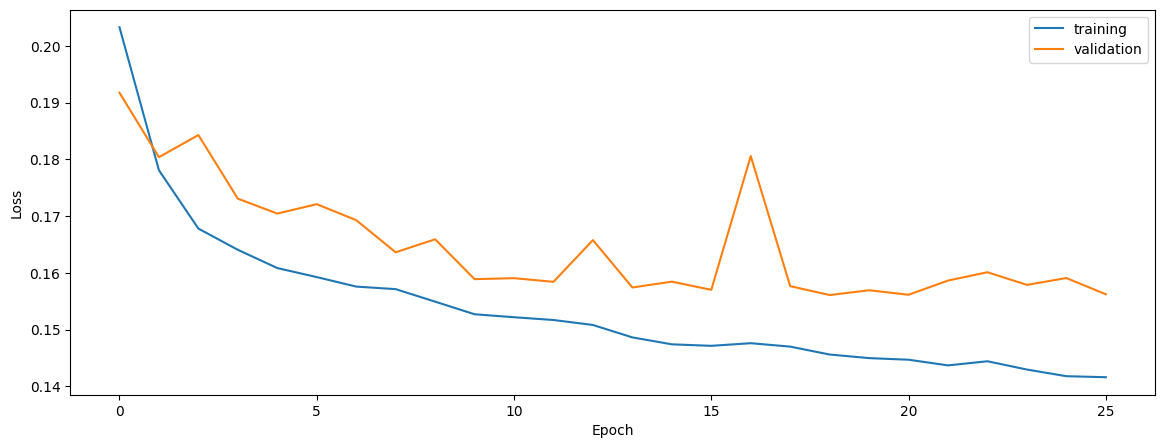

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('normalized')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

normalized
0.6595775807604272
0.6357656447534766
0.6514238330232182


In [16]:
print('native')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

native
0.6550322201251859
0.6413811780636425
0.655126601197923


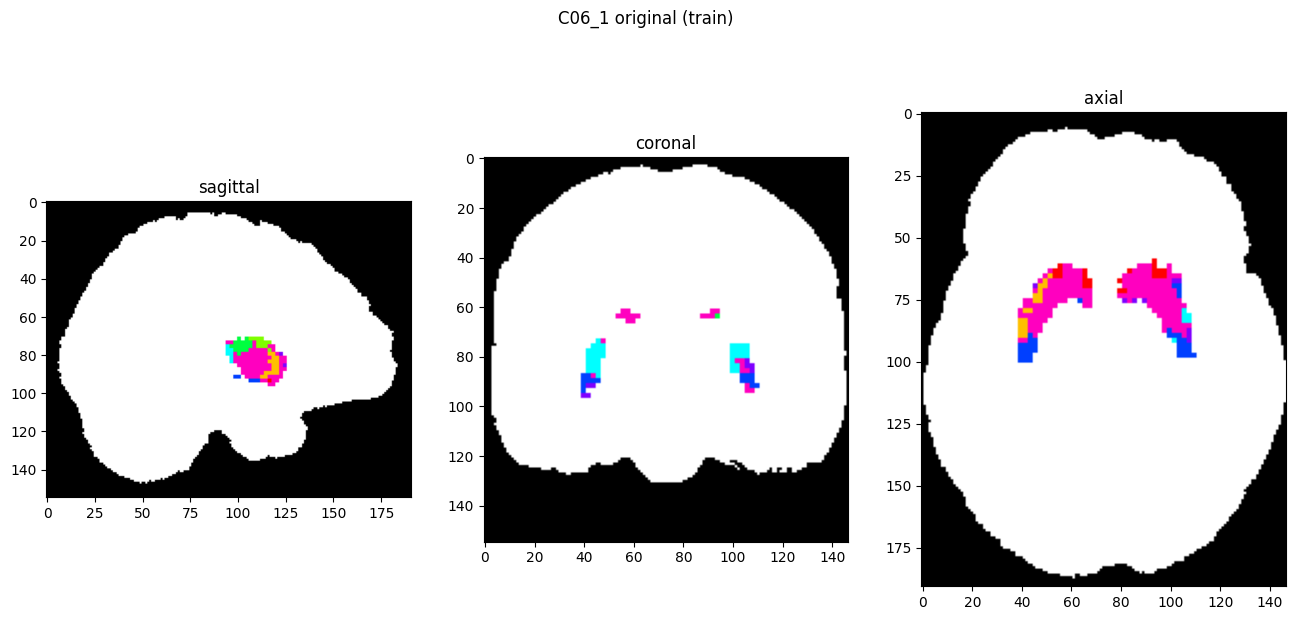

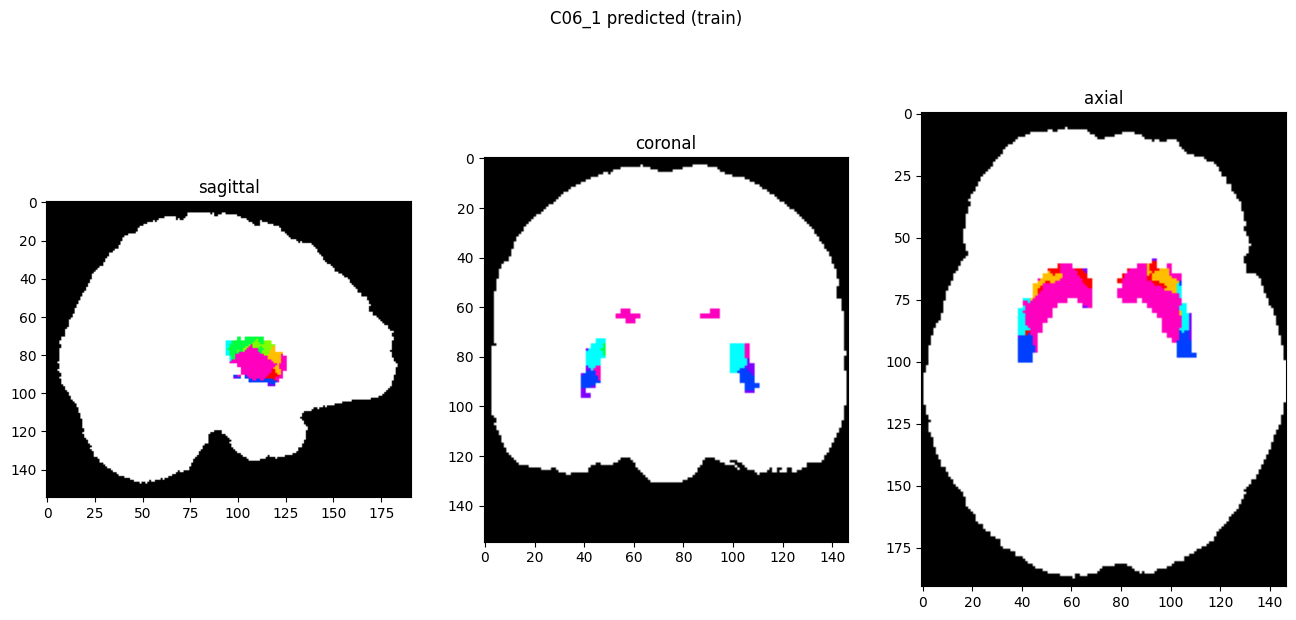

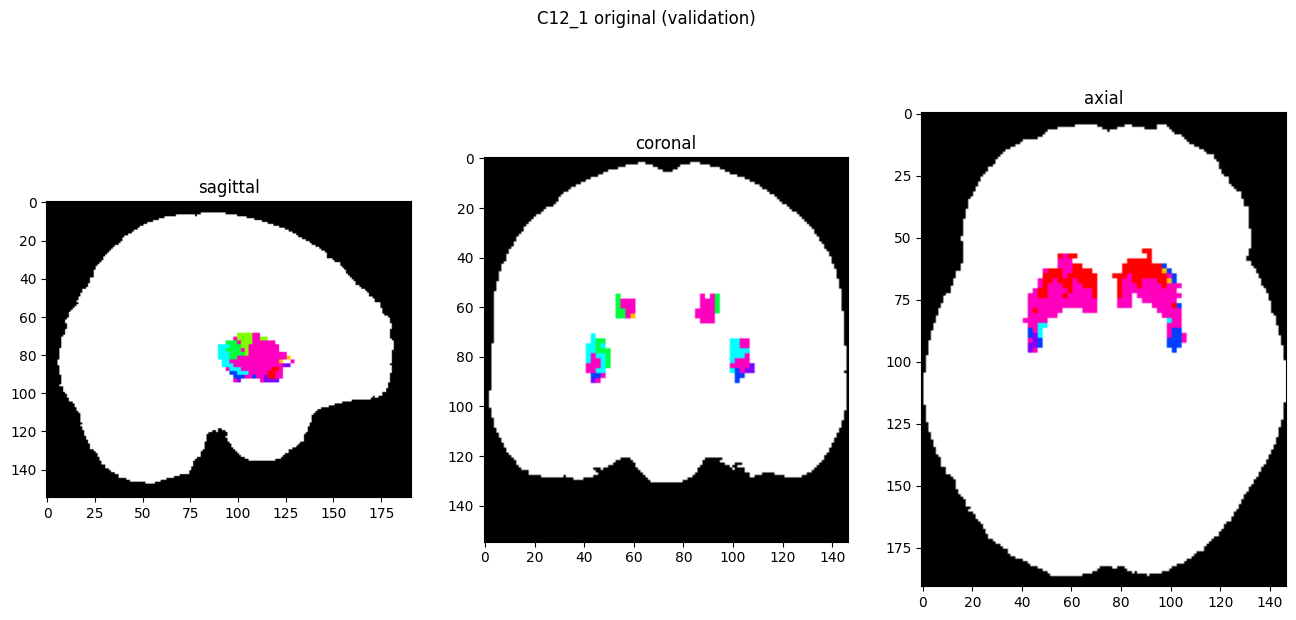

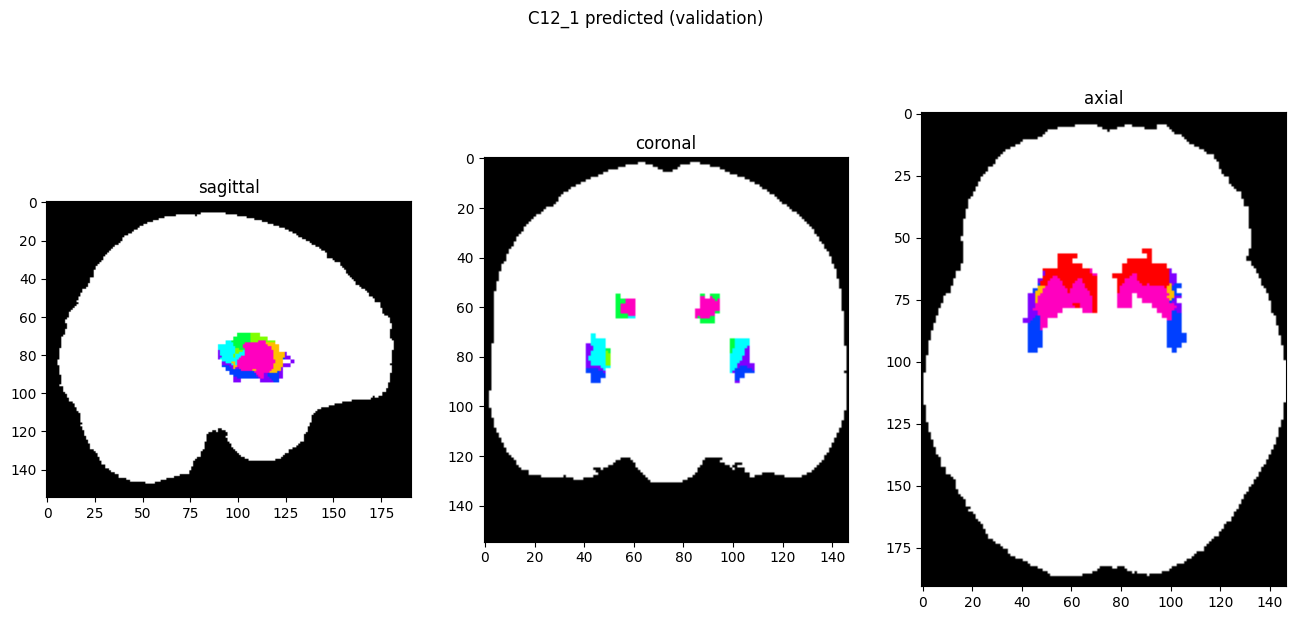

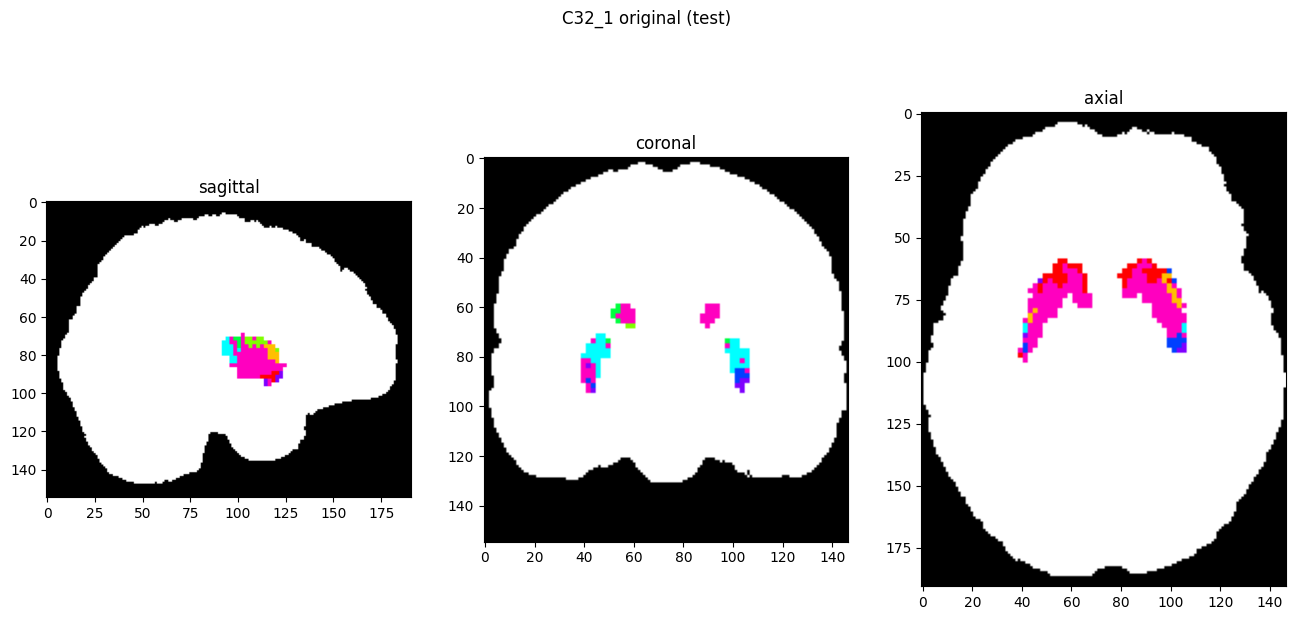

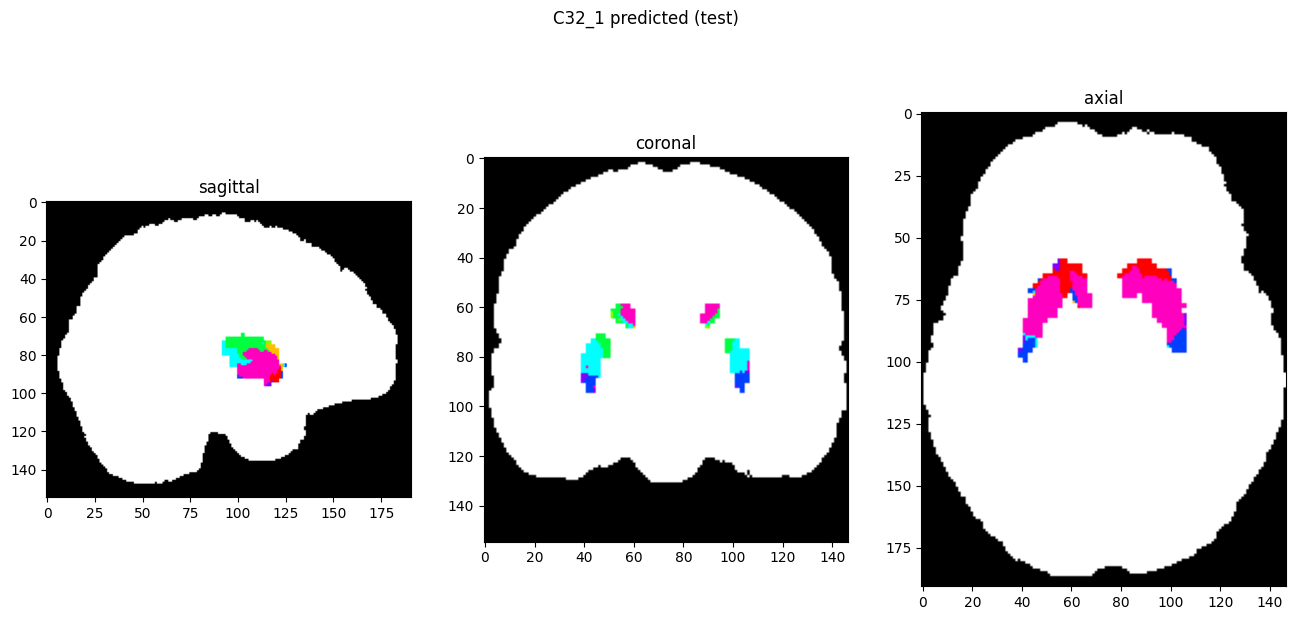

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)